<a href="https://colab.research.google.com/github/PhuongAnh2212/stock-prediction/blob/main/210191_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample

In [56]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load data from csv file
data_appl = pd.read_csv('AAPL.csv')

In [ ]:
# Show some first data samples
data_appl.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,17-12-1980,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,18-12-1980,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


In [ ]:
# Get some info about the data
data_appl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10590 non-null  object 
 1   Low             10590 non-null  float64
 2   Open            10590 non-null  float64
 3   Volume          10590 non-null  int64  
 4   High            10590 non-null  float64
 5   Close           10590 non-null  float64
 6   Adjusted Close  10590 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 579.3+ KB


In [ ]:
### Split the dataset into time windows to get data samples.

df=data_appl
X_data = []
y_data = []
window_size=30 # Time window for data feature (size of 'number of days').

# Only get the open price (index 2 in the data frame)
for i in range(1, len(df) - window_size - 1):
    first = df.iloc[i, 2]
    data_feature = []
    data_label = []

    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df.iloc[i + j, 2])

    # Next value is the label (price of the next day) to be predicted
    data_label.append(df.iloc[i + window_size, 2])

    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))


In [ ]:
### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (6756, 30, 1)
Shape of validation set:  (1690, 30, 1)
Shape of test set:  (2112, 30, 1)


In [ ]:
X_train.shape


(6756, 30, 1)

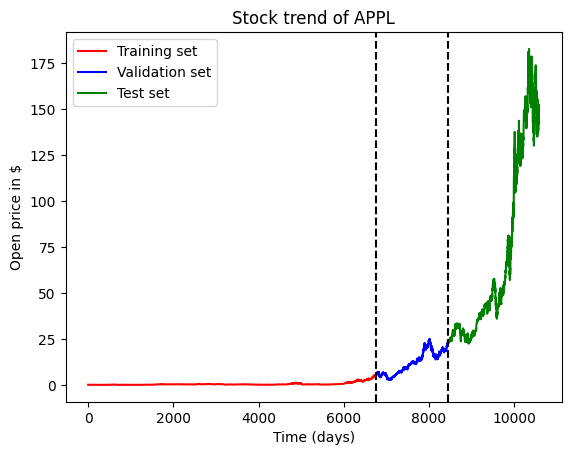

In [ ]:
# Visualize the training, validation and test set
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of APPL")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Create and train the model

# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - loss: 0.3410 - mse: 0.3410 - val_loss: 0.1420 - val_mse: 0.1420
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - loss: 0.1447 - mse: 0.1447 - val_loss: 0.1019 - val_mse: 0.1019
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.0909 - mse: 0.0909 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 0.0748 - mse: 0.0748 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0429 - val_mse: 0.0429


In [ ]:
model.save('trained_model.h5')

In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
MSE on the test set:  0.04243559724712108


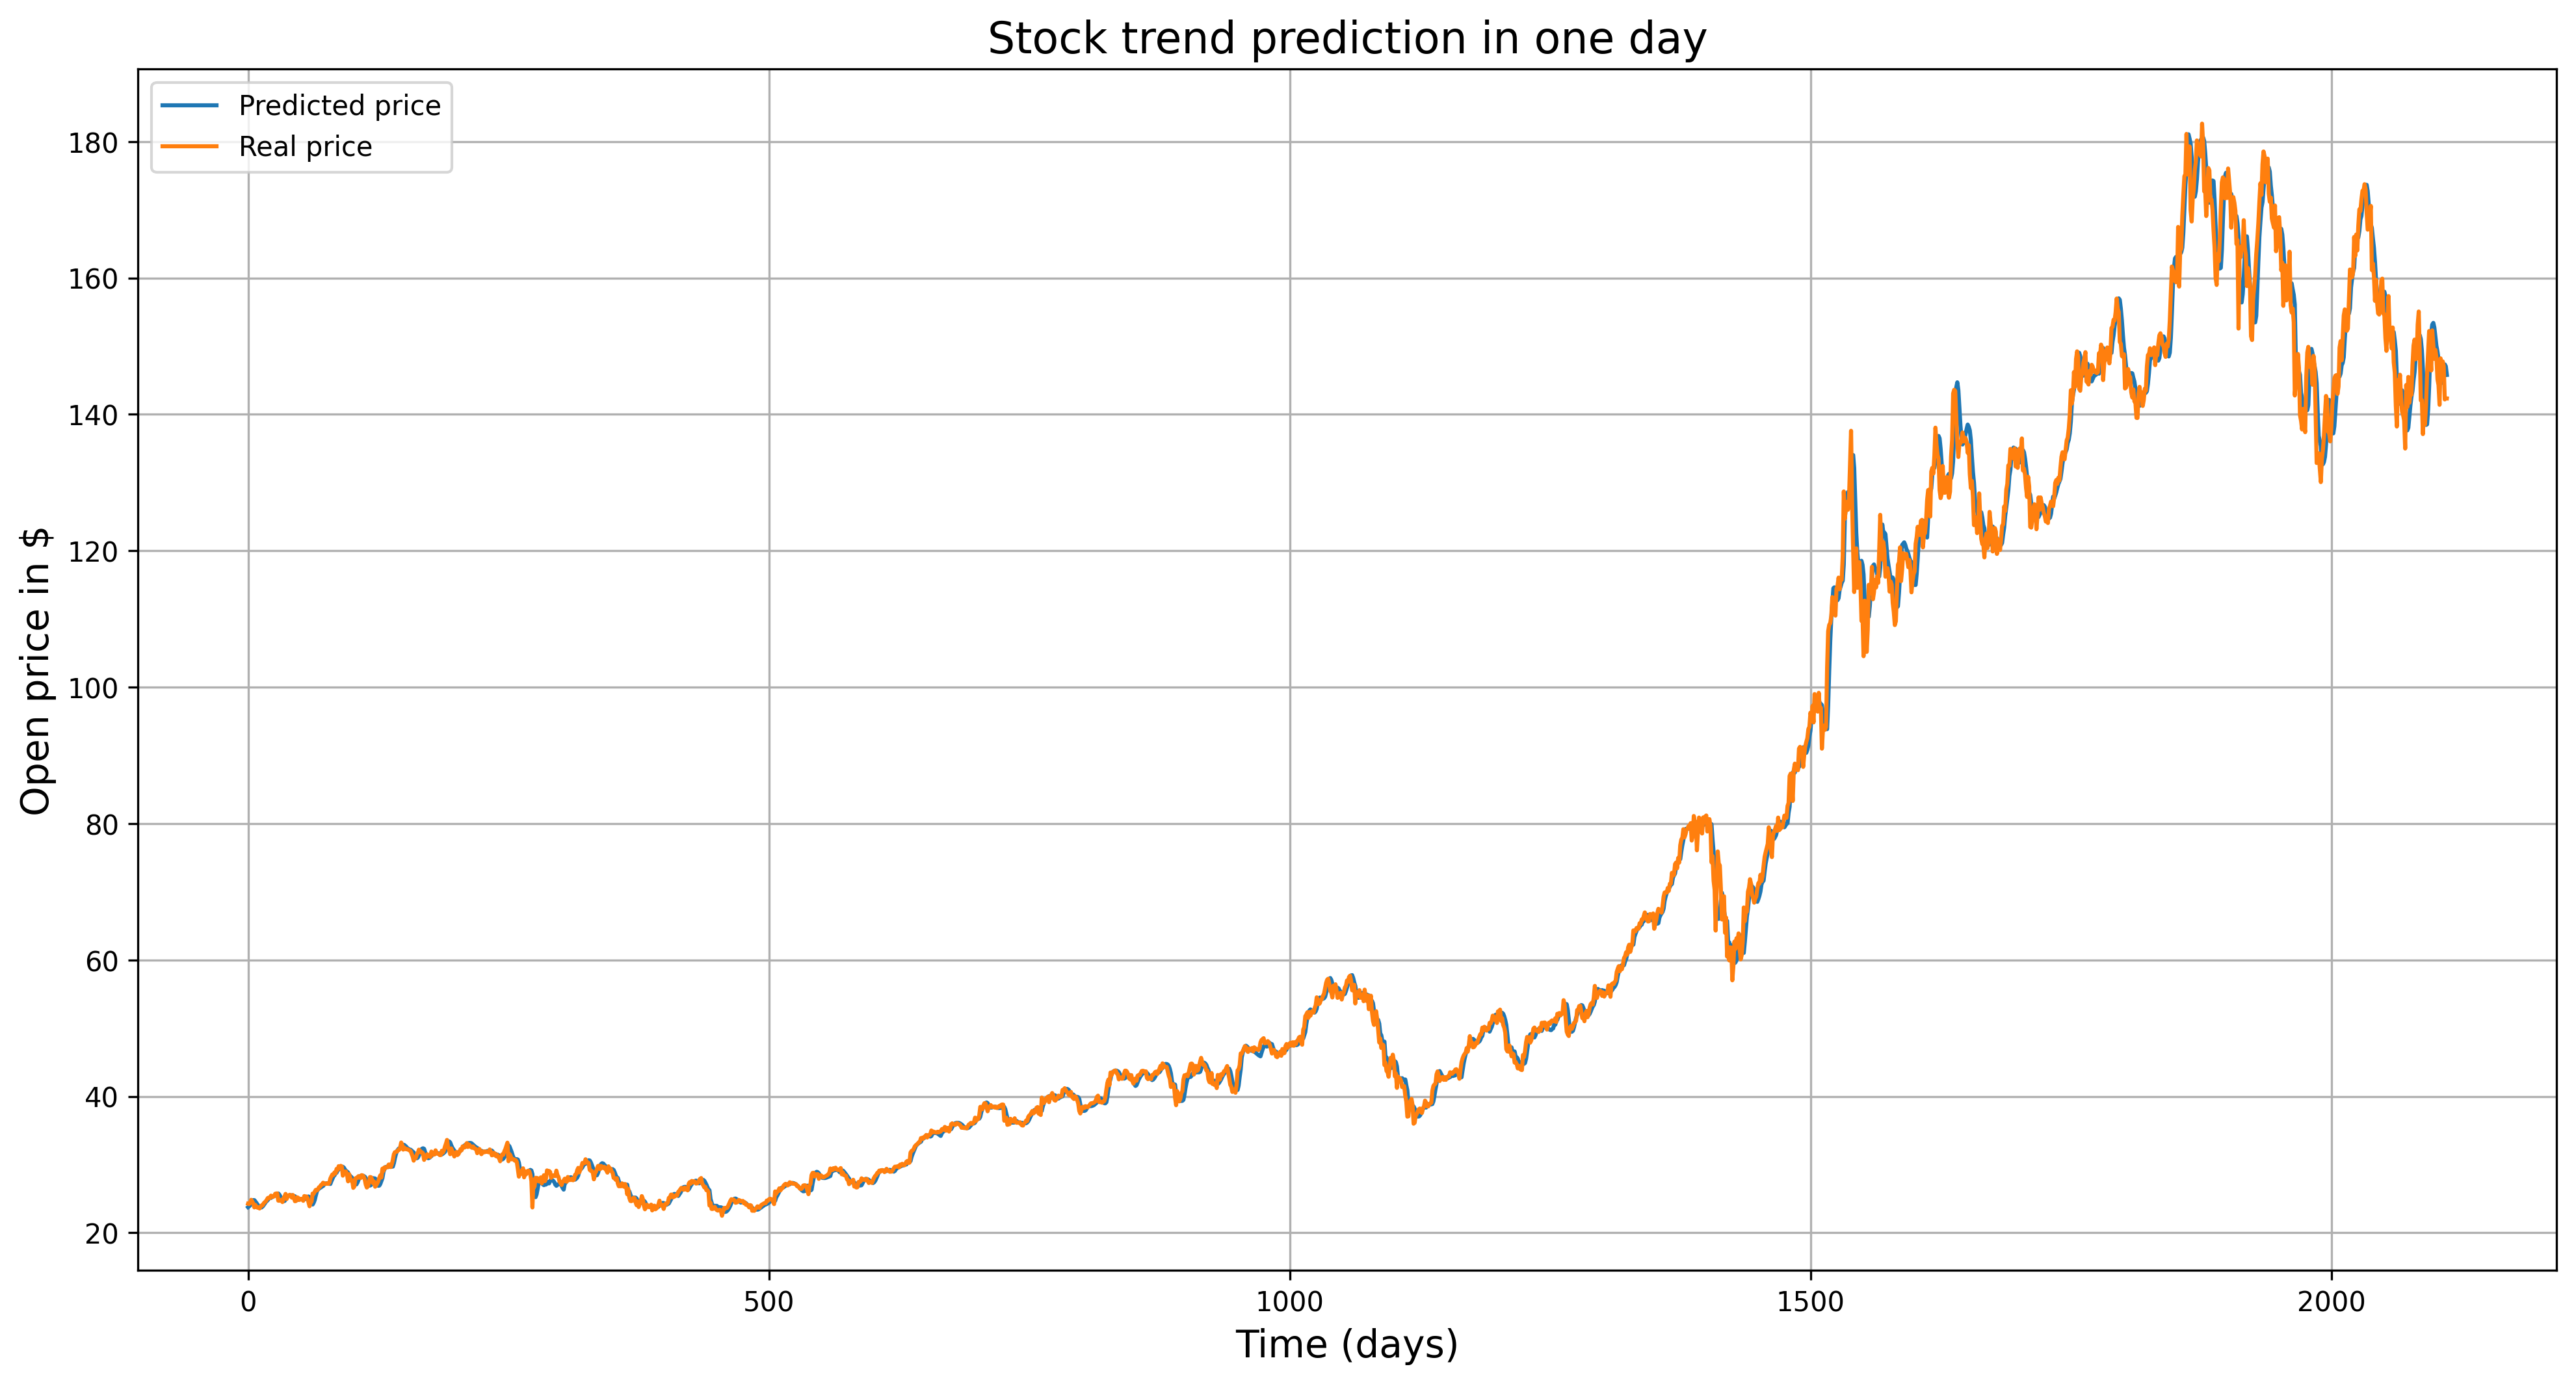

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# Nasdaq stock price prediction

In [57]:
file_paths = [
'AAL.csv',
'AAME.csv',
'AAOI.csv',
'AAON.csv',
'AAPL.csv',
'AAVL.csv',
'AAWW.csv',
'ABCB.csv',
'ABCD.csv',
'ABCO.csv',
'ABIO.csv',
'ABMD.csv',
'ACAD.csv',
'ACET.csv',
'ACFC.csv',
'ACFN.csv',
'ACGL.csv',
'ACHC.csv',
'ACHN.csv',
'ACIW.csv',
'ACLS.csv',
'ACNB.csv',
'ACOR.csv',
'ACRX.csv',
'ACST.csv',
'ACTA.csv',
'ACTG.csv',
'ACUR.csv',
'ADBE.csv',
'ADES.csv',
'ADI.csv',
'ADMA.csv',
'ADMP.csv',
'ADP.csv',
'ADSK.csv',
'ADTN.csv',
'ADUS.csv',
'ADXS.csv',
'AEHR.csv',
'AEIS.csv',
'AELTF.csv',
'AERI.csv',
'AEY.csv',
'AEZS.csv',
'AFAM.csv',
'AFCB.csv',
'AFMD.csv',
'AFSI.csv',
'AGEN.csv',
'AGIO.csv',
'AGRX.csv',
'AGTC.csv',
'AGYS.csv',
'AHGP.csv',
'AHPI.csv',
'AIMC.csv',
'AIQ.csv',
'AIRT.csv',
'AJISF.csv',
'AKAM.csv',
'AKBA.csv',
'ALCO.csv',
'ALDX.csv',
'ALGN.csv',
'ALGT.csv',
'ALIM.csv',
'ALKS.csv',
'ALLT.csv',
'ALNY.csv',
'ALOG.csv',
'ALSD.csv']
data_frames = []

# Read each file and store the data in a DataFrame
for file_path in file_paths:
    df = pd.read_csv(file_path)
    data_frames.append(df)

In [58]:
df=pd.concat(data_frames, axis = 0)
# Sort the data by date
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)
# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Filter the data to keep the desired time period (e.g., 2010 to 2022)
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2022-12-31')
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [59]:
df_filtered

,Date,Low,Open,Volume,High,Close,Adjusted Close
471,2010-02-01,6.160000,6.160000,132639.0,6.300000,6.290000,6.290000
472,2010-02-01,36.490002,36.689999,254400.0,37.480000,37.369999,37.369999
473,2010-02-01,35.520000,36.270000,141750.0,36.270000,36.029999,32.706196
474,2010-02-01,12.400000,12.400000,2600.0,12.450000,12.450000,7.560537
475,2010-02-01,23.549999,23.730000,3697900.0,24.080000,23.809999,23.809999
...,...,...,...,...,...,...,...
385260,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN
385261,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN
385262,2021-12-31,34.669998,34.840000,461500.0,35.130001,34.700001,34.700001
385263,2021-12-31,91.989998,92.940002,242900.0,94.580002,94.120003,94.120003


In [60]:
### Split the dataset into time windows to get data samples.
X_data = []
y_data = []
window_size=7 # Time window for data feature (size of 'number of days').

features = ['Low', 'High', 'Open', 'Close', 'Adj Close', 'Volume']

for i in range(1, len(df_filtered) - window_size - 1):
    first = df_filtered.iloc[i, 2]
    data_feature = []
    data_label = []

    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df_filtered.iloc[i + j, 2])

    # Next value is the label (price of the next day) to be predicted
    data_label.append(df_filtered.iloc[i + window_size, 2])

    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Visualize the training, validation and test set
df_plot = df_filtered['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]
# Replace NaN values with mean of the non-missing values in each feature column
X_train_filled = np.nan_to_num(X_train, nan=np.nanmean(X_train), copy=True)
X_val_filled = np.nan_to_num(X_val, nan=np.nanmean(X_val), copy=True)
X_test_filled = np.nan_to_num(X_test, nan=np.nanmean(X_test), copy=True)

# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train_filled.copy()
X_val_norm = X_val_filled.copy()
X_test_norm = X_test_filled.copy()

for i in range(X_train_filled.shape[1]):
    min_feature = np.min(X_train_filled[:, i])
    max_feature = np.max(X_train_filled[:, i])
    if max_feature != min_feature:
        X_train_norm[:, i] = (X_train_filled[:, i] - min_feature) / (max_feature - min_feature)
        X_val_norm[:, i] = (X_val_filled[:, i] - min_feature) / (max_feature - min_feature)
        X_test_norm[:, i] = (X_test_filled[:, i] - min_feature) / (max_feature - min_feature)

# Replace NaN values with mean of the non-missing values in the target variable
y_train_filled = np.nan_to_num(y_train, nan=np.nanmean(y_train), copy=True)
y_val_filled = np.nan_to_num(y_val, nan=np.nanmean(y_val), copy=True)
y_test_filled = np.nan_to_num(y_test, nan=np.nanmean(y_test), copy=True)

# MinMax normalize the target variable: y=(y-min(y)/(max(y)-min(y))
y_min = np.min(y_train_filled)
y_max = np.max(y_train_filled)

if y_max != y_min:
    y_train_norm = (y_train_filled - y_min) / (y_max - y_min)
    y_val_norm = (y_val_filled - y_min) / (y_max - y_min)
    y_test_norm = (y_test_filled - y_min) / (y_max - y_min)
else:
    print("Error: Division by zero during target variable normalization.")

# Build the model architecture and train the model
model = tf.keras.Sequential()
model.add(LSTM(units=50, input_shape=(window_size, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="relu"))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs=5, batch_size=512)


Epoch 1/5


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


258/258 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026


In [61]:
# MinMax normalize the testing data using the same minimum and maximum values from training data
X_test_norm = (X_test_filled - np.min(X_train_filled)) / (np.max(X_train_filled) - np.min(X_train_filled))
y_test_norm = (y_test_filled - np.min(y_train_filled)) / (np.max(y_train_filled) - np.min(y_train_filled))

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))



1290/1290 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


NameError: name 'mean_squared_error' is not defined

In [ ]:
### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (132096, 7, 1)
Shape of validation set:  (33024, 7, 1)
Shape of test set:  (41280, 7, 1)


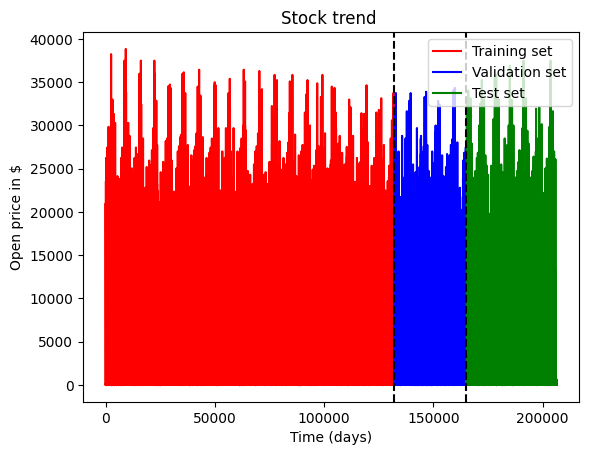

In [ ]:
# Visualize the training, validation and test set
df_plot = df_filtered['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend ")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
# Replace NaN values with mean of the non-missing values in each feature column
X_train_filled = np.nan_to_num(X_train, nan=np.nanmean(X_train), copy=True)
X_val_filled = np.nan_to_num(X_val, nan=np.nanmean(X_val), copy=True)
X_test_filled = np.nan_to_num(X_test, nan=np.nanmean(X_test), copy=True)

# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train_filled.copy()
X_val_norm = X_val_filled.copy()
X_test_norm = X_test_filled.copy()

for i in range(X_train_filled.shape[1]):
    min_feature = np.min(X_train_filled[:, i])
    max_feature = np.max(X_train_filled[:, i])
    if max_feature != min_feature:
        X_train_norm[:, i] = (X_train_filled[:, i] - min_feature) / (max_feature - min_feature)
        X_val_norm[:, i] = (X_val_filled[:, i] - min_feature) / (max_feature - min_feature)
        X_test_norm[:, i] = (X_test_filled[:, i] - min_feature) / (max_feature - min_feature)

# Replace NaN values with mean of the non-missing values in the target variable
y_train_filled = np.nan_to_num(y_train, nan=np.nanmean(y_train), copy=True)
y_val_filled = np.nan_to_num(y_val, nan=np.nanmean(y_val), copy=True)
y_test_filled = np.nan_to_num(y_test, nan=np.nanmean(y_test), copy=True)

# MinMax normalize the target variable: y=(y-min(y)/(max(y)-min(y))
y_min = np.min(y_train_filled)
y_max = np.max(y_train_filled)

if y_max != y_min:
    y_train_norm = (y_train_filled - y_min) / (y_max - y_min)
    y_val_norm = (y_val_filled - y_min) / (y_max - y_min)
    y_test_norm = (y_test_filled - y_min) / (y_max - y_min)
else:
    print("Error: Division by zero during target variable normalization.")

# Build the model architecture and train the model
model = tf.keras.Sequential()
model.add(LSTM(units=50, input_shape=(window_size, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="relu"))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs=5, batch_size=512)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026


In [ ]:
# MinMax normalize the testing data using the same minimum and maximum values from training data
X_test_norm = (X_test_filled - np.min(X_train_filled)) / (np.max(X_train_filled) - np.min(X_train_filled))
y_test_norm = (y_test_filled - np.min(y_train_filled)) / (np.max(y_train_filled) - np.min(y_train_filled))

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))


1290/1290 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
MSE on the test set:  0.002678202125775648


# ADBE


In [ ]:
# Load data from csv file
data_adbe = pd.read_csv('ADBE.csv')
data_msft = pd.read_csv('MSFT.csv')
data_amzn = pd.read_csv('AMZN.csv')
data_nflx = pd.read_csv('NFLX.csv')

In [ ]:
data_adbe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9158 entries, 0 to 9157
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            9158 non-null   object 
 1   Low             9158 non-null   float64
 2   Open            9158 non-null   float64
 3   Volume          9158 non-null   int64  
 4   High            9158 non-null   float64
 5   Close           9158 non-null   float64
 6   Adjusted Close  9158 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 501.0+ KB


In [ ]:
def prepare_data(company_data, window_size):
    X_data = []
    y_data = []

    # Only get the open price (replace index 2 if necessary)
    for i in range(1, len(company_data) - window_size - 1):
        first = company_data.iloc[i, 2]
        data_feature = []
        data_label = []

        # Get a window_size time frame for data feature
        for j in range(window_size):
            data_feature.append(company_data.iloc[i + j, 2])

        # Next value is the label (price of the next day) to be predicted
        data_label.append(company_data.iloc[i + window_size, 2])

        # Append new data sample (feature and label) to X_data and y_data
        X_data.append(np.array(data_feature).reshape(window_size, 1))
        y_data.append(np.array(data_label))

    return np.array(X_data), np.array(y_data)


In [ ]:
window_size = 30

In [ ]:
X_data, y_data = prepare_data(data_adbe, window_size)

In [ ]:
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

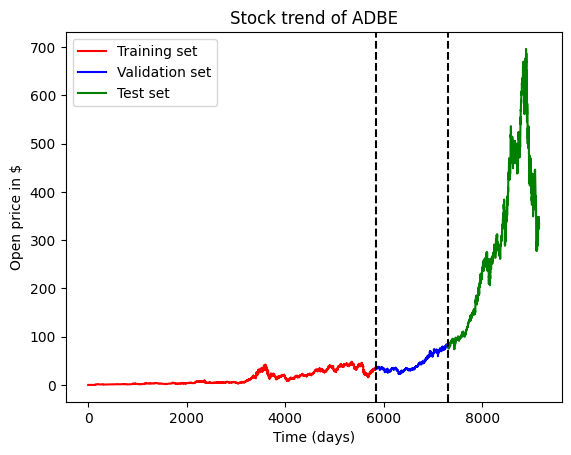

In [ ]:
# Visualize the training, validation and test set
df_plot = data_adbe['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of ADBE")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
def normalize_data(X_train, y_train, X_val, y_val):
    X_train_norm = X_train.copy()
    y_train_norm = y_train.copy()
    X_val_norm = X_val.copy()
    y_val_norm = y_val.copy()

    for i in range(len(X_train)):
        min_feature = np.min(X_train[i])
        max_feature = np.max(X_train[i])
        if max_feature != min_feature:
            X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
            y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

    for i in range(len(X_val)):
        min_feature = np.min(X_val[i])
        max_feature = np.max(X_val[i])
        if max_feature != min_feature:
            X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
            y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

    return X_train_norm, y_train_norm, X_val_norm, y_val_norm


In [ ]:
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - loss: 0.8263 - mse: 0.8263 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.1163 - mse: 0.1163 - val_loss: 0.1018 - val_mse: 0.1018
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0925 - mse: 0.0925 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0706 - mse: 0.0706 - val_loss: 0.0637 - val_mse: 0.0637
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0597 - mse: 0.0597 - val_loss: 0.0563 - val_mse: 0.0563


In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
MSE on the test set:  0.04886516473221313


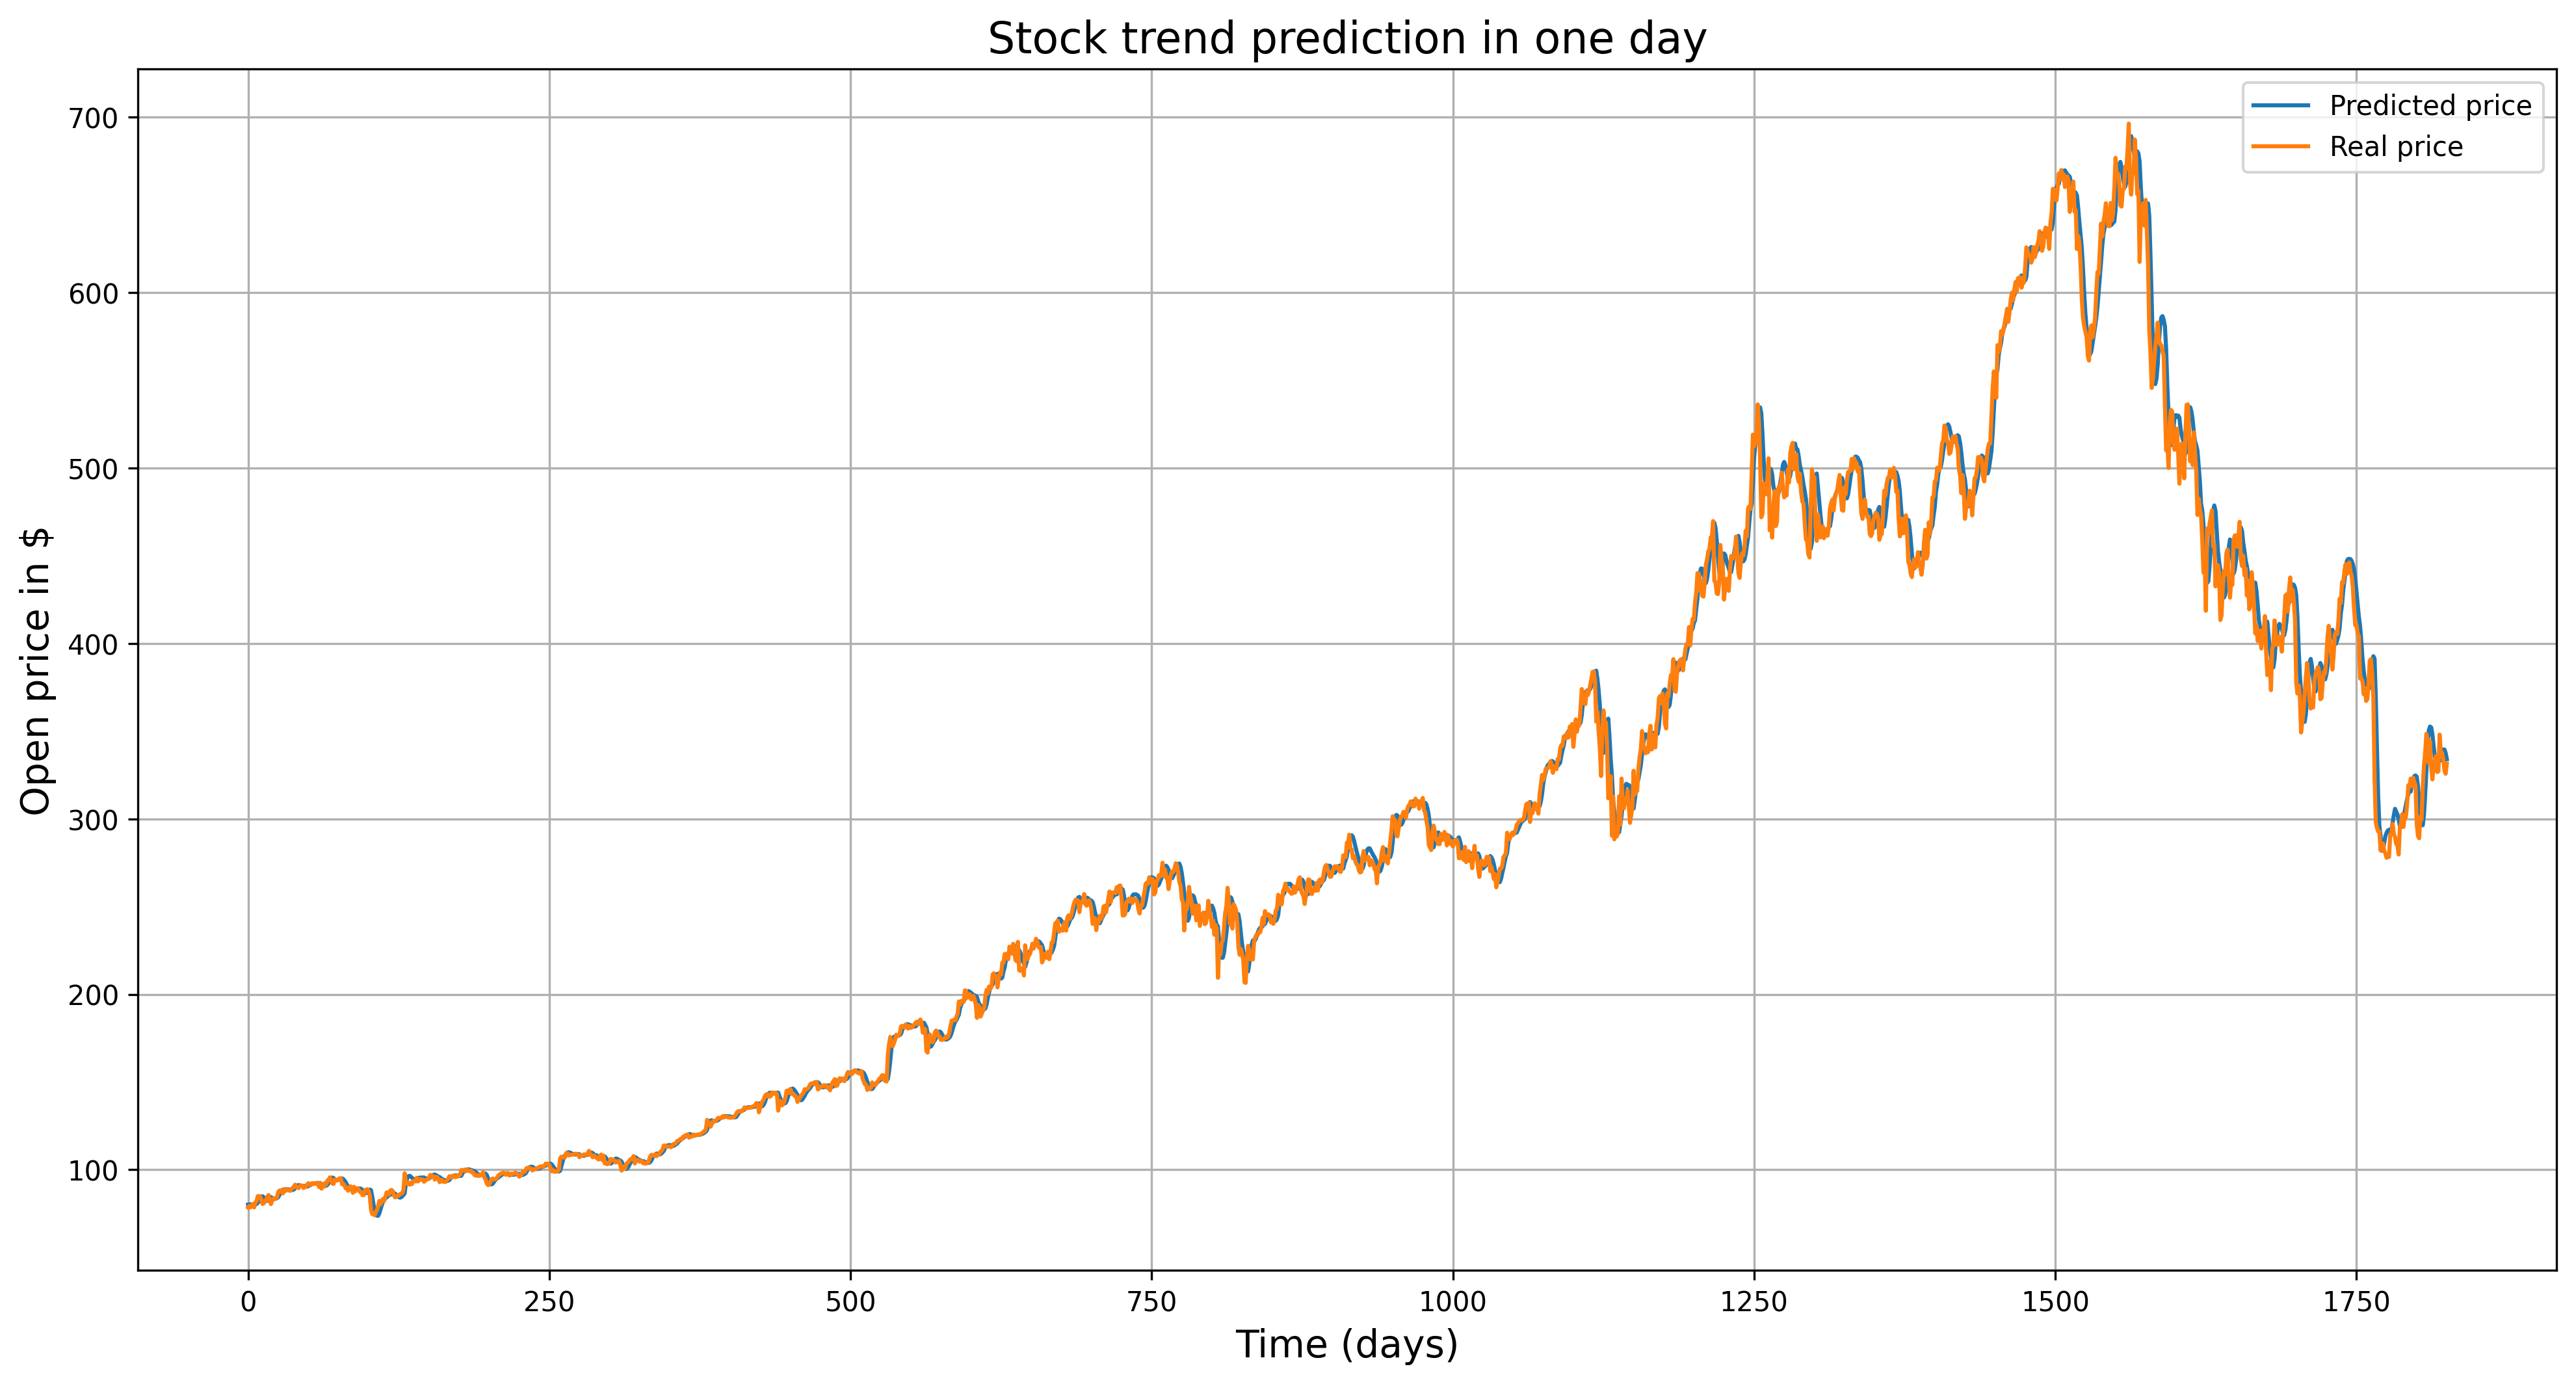

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# MSFT

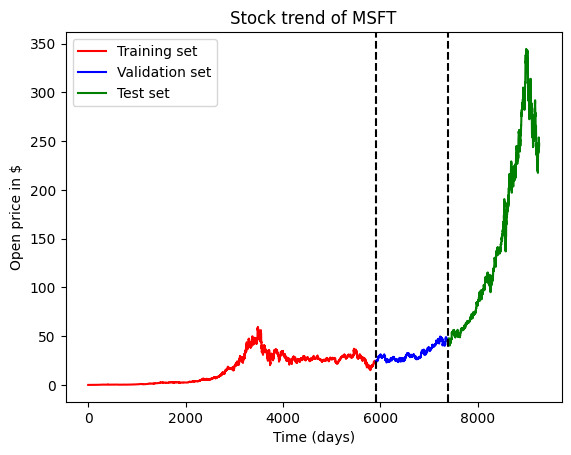

In [ ]:
X_data, y_data = prepare_data(data_msft, window_size)
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Visualize the training, validation and test set
df_plot = data_msft['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of MSFT")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - loss: 2.6820 - mse: 2.6820 - val_loss: 0.1928 - val_mse: 0.1928
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - loss: 0.1836 - mse: 0.1836 - val_loss: 0.1401 - val_mse: 0.1401
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 0.1273 - mse: 0.1273 - val_loss: 0.0928 - val_mse: 0.0928
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0928 - mse: 0.0928 - val_loss: 0.0896 - val_mse: 0.0896
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - loss: 0.0806 - mse: 0.0806 - val_loss: 0.0712 - val_mse: 0.0712


In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
MSE on the test set:  0.07489684728485893


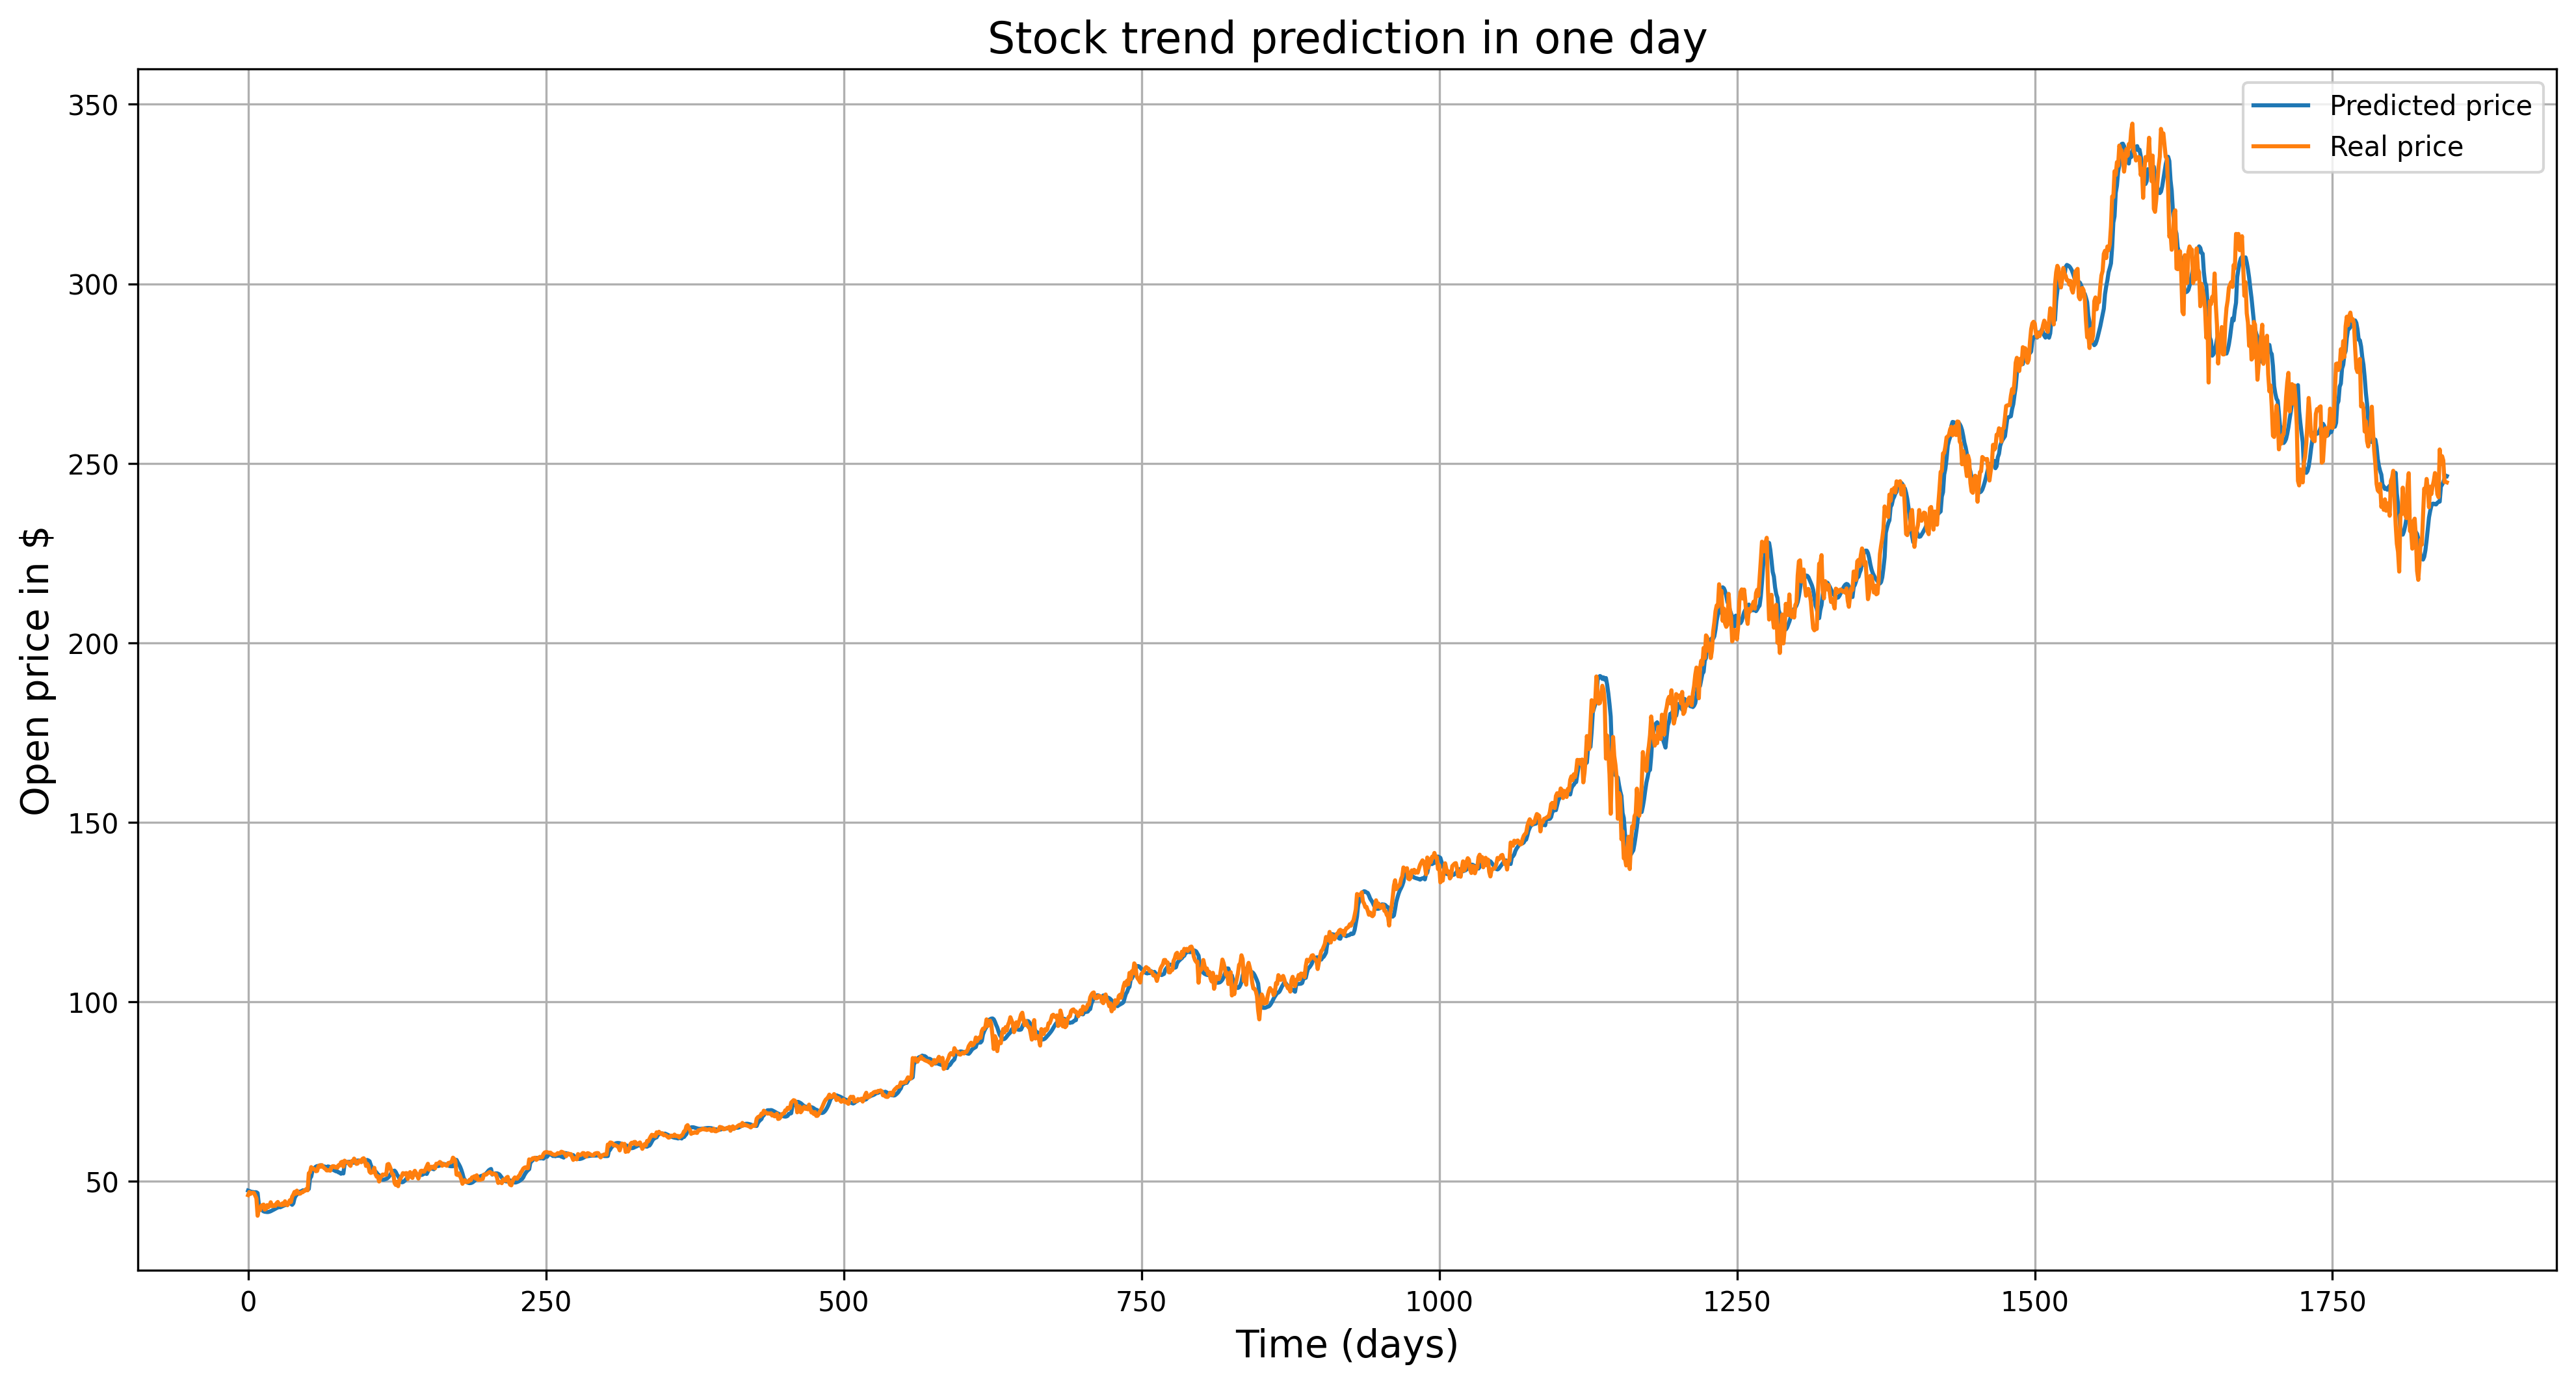

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# AMZN

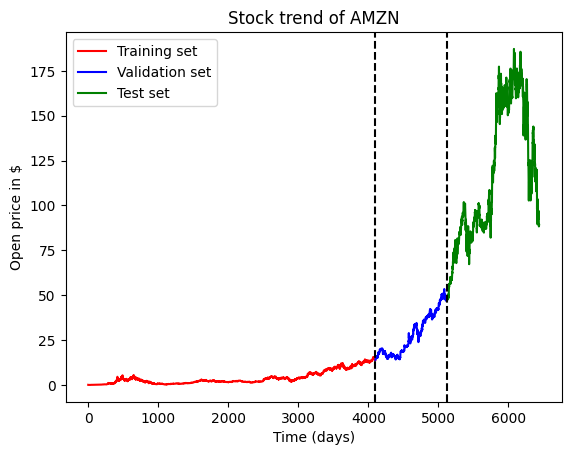

In [ ]:
X_data, y_data = prepare_data(data_amzn, window_size)
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Visualize the training, validation and test set
df_plot = data_amzn['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of AMZN")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - loss: 1.5020 - mse: 1.5020 - val_loss: 0.2784 - val_mse: 0.2784
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.2298 - mse: 0.2298 - val_loss: 0.1449 - val_mse: 0.1449
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.1551 - mse: 0.1551 - val_loss: 0.1567 - val_mse: 0.1567
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.1154 - mse: 0.1154 - val_loss: 0.0965 - val_mse: 0.0965
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0985 - mse: 0.0985 - val_loss: 0.0949 - val_mse: 0.0949


In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MSE on the test set:  0.07915971729233376


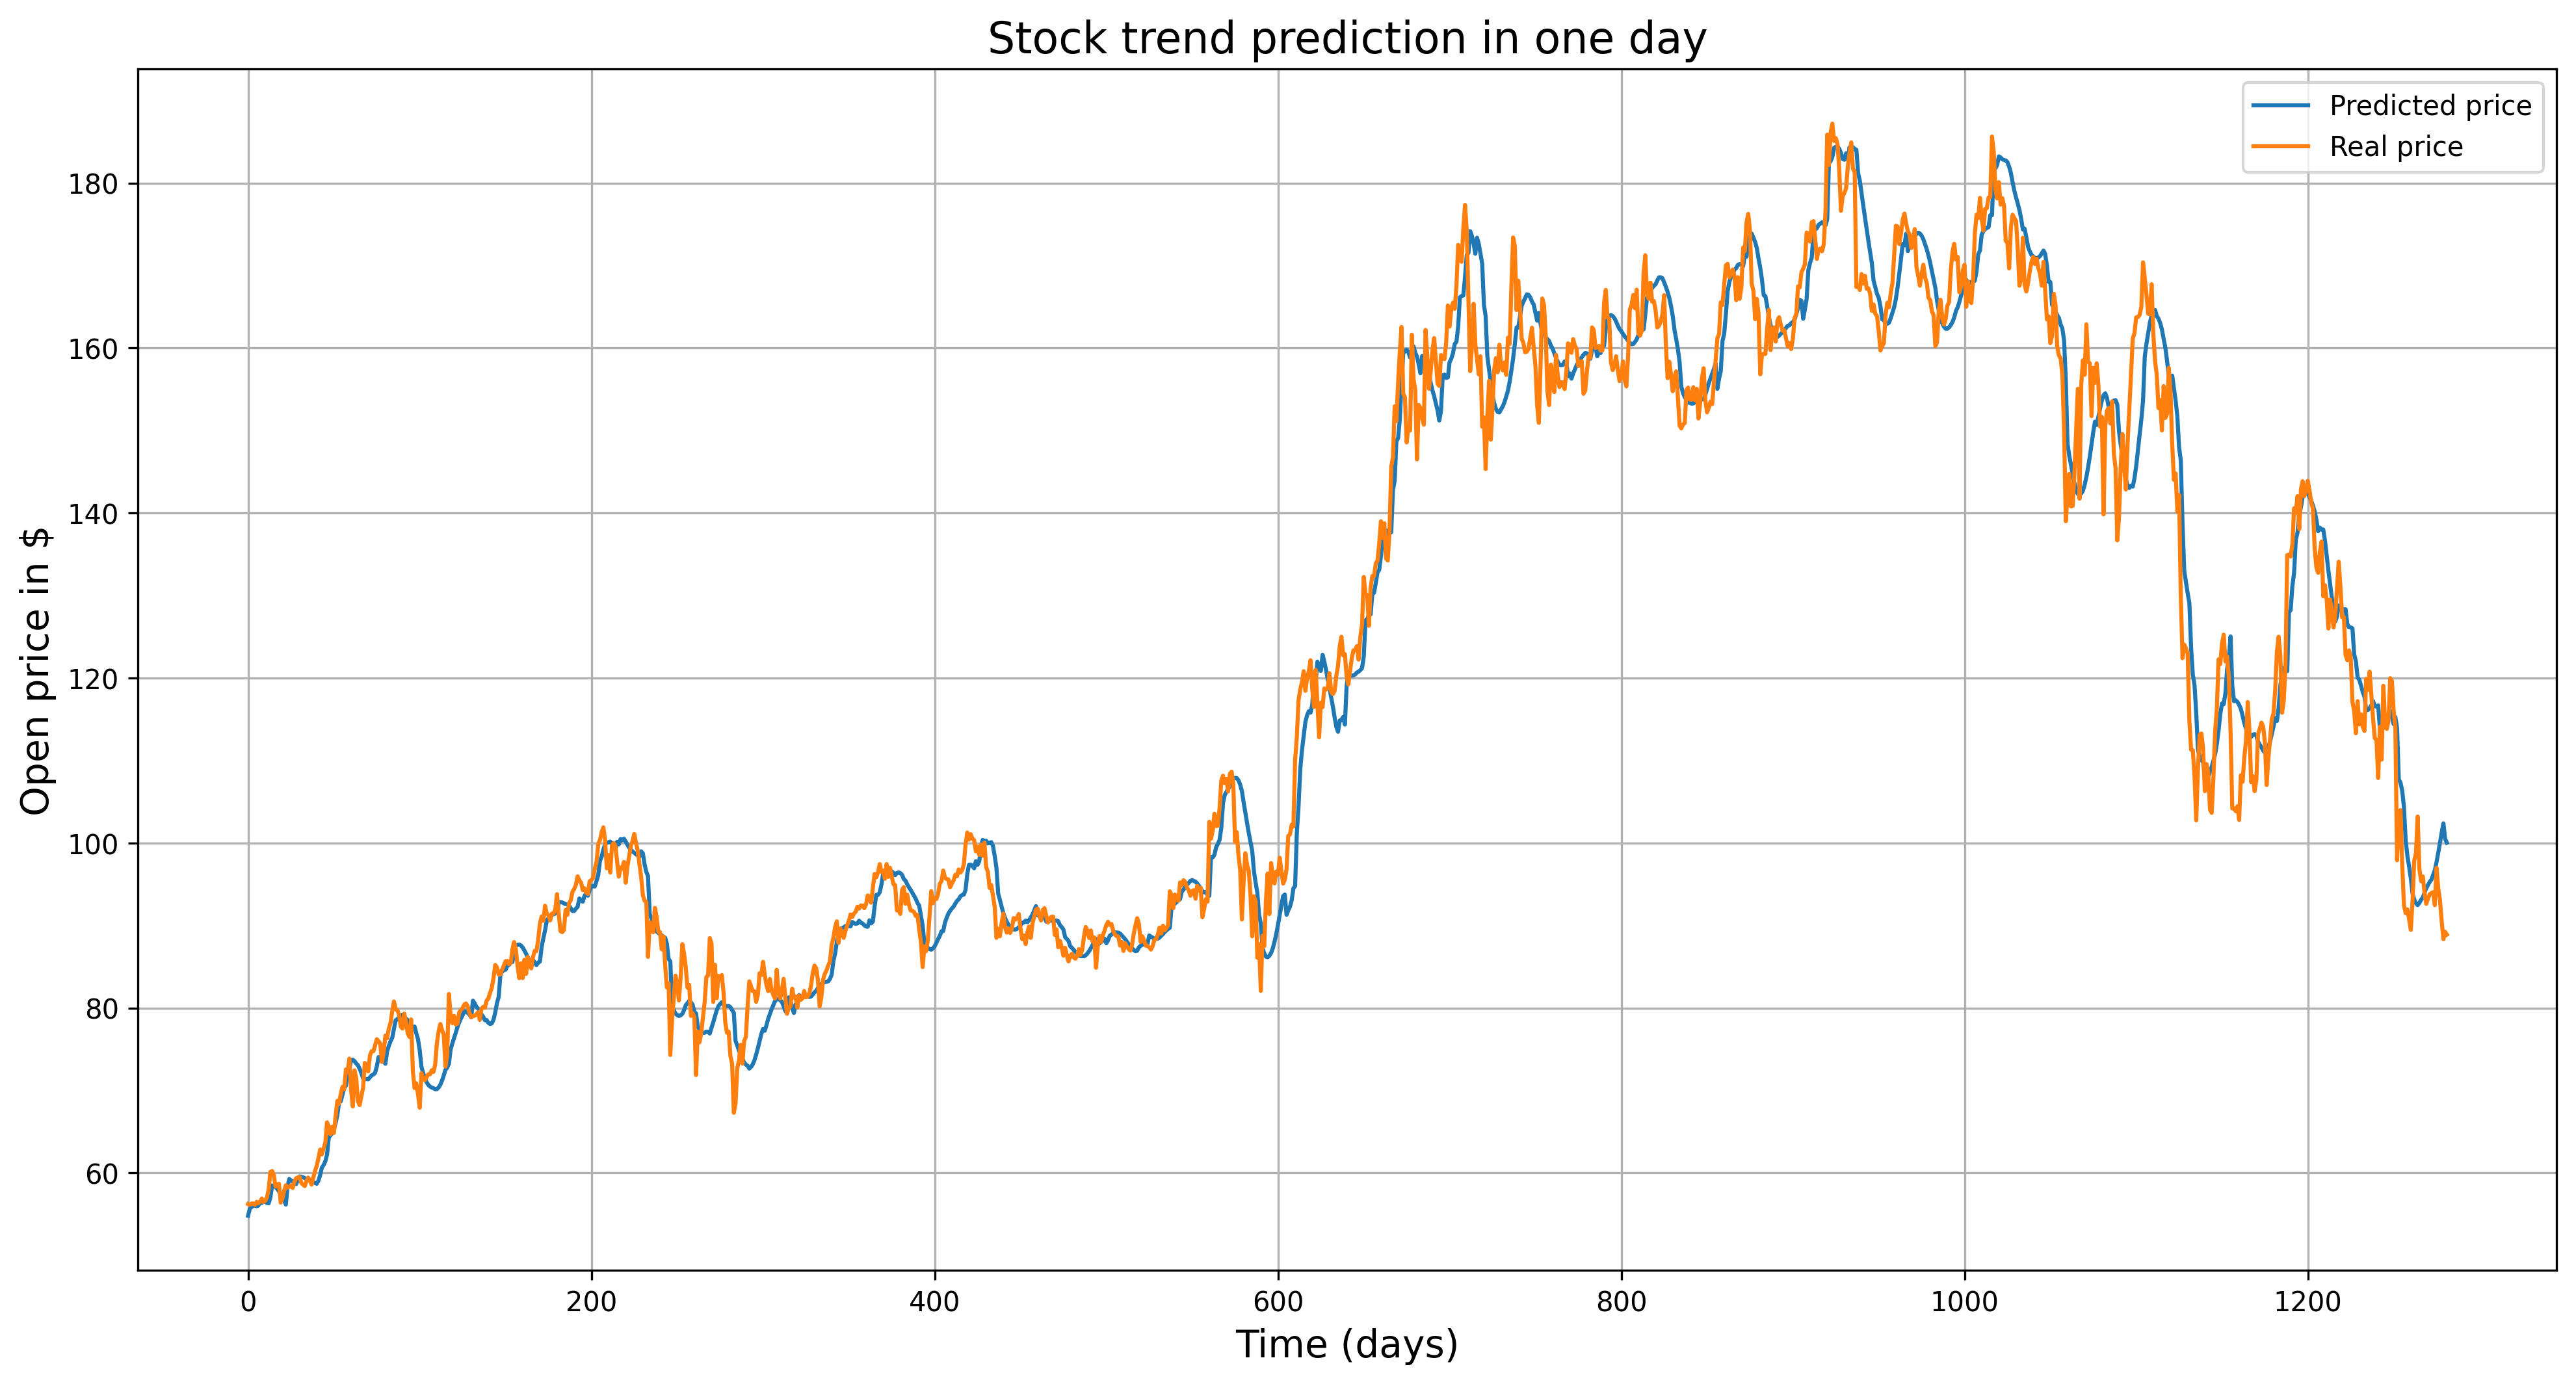

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# NFLX

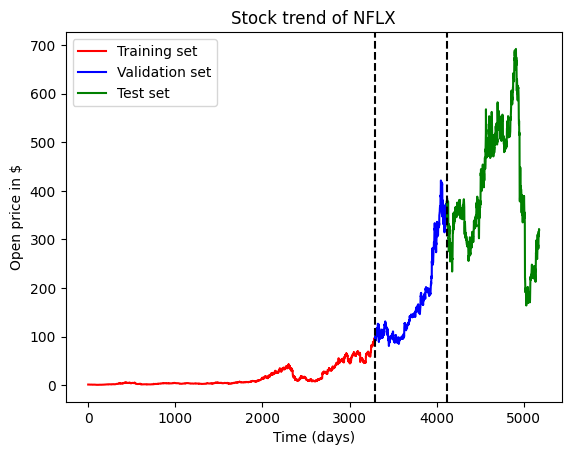

In [ ]:
X_data, y_data = prepare_data(data_nflx, window_size)
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Visualize the training, validation and test set
df_plot = data_nflx['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of NFLX")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()


In [ ]:
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - loss: 0.4772 - mse: 0.4772 - val_loss: 0.1585 - val_mse: 0.1585
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - loss: 0.2288 - mse: 0.2288 - val_loss: 0.1513 - val_mse: 0.1513
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.1712 - mse: 0.1712 - val_loss: 0.1413 - val_mse: 0.1413
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.1295 - mse: 0.1295 - val_loss: 0.0916 - val_mse: 0.0916
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.1044 - mse: 0.1044 - val_loss: 0.0885 - val_mse: 0.0885


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MSE on the test set:  0.09213711717222103


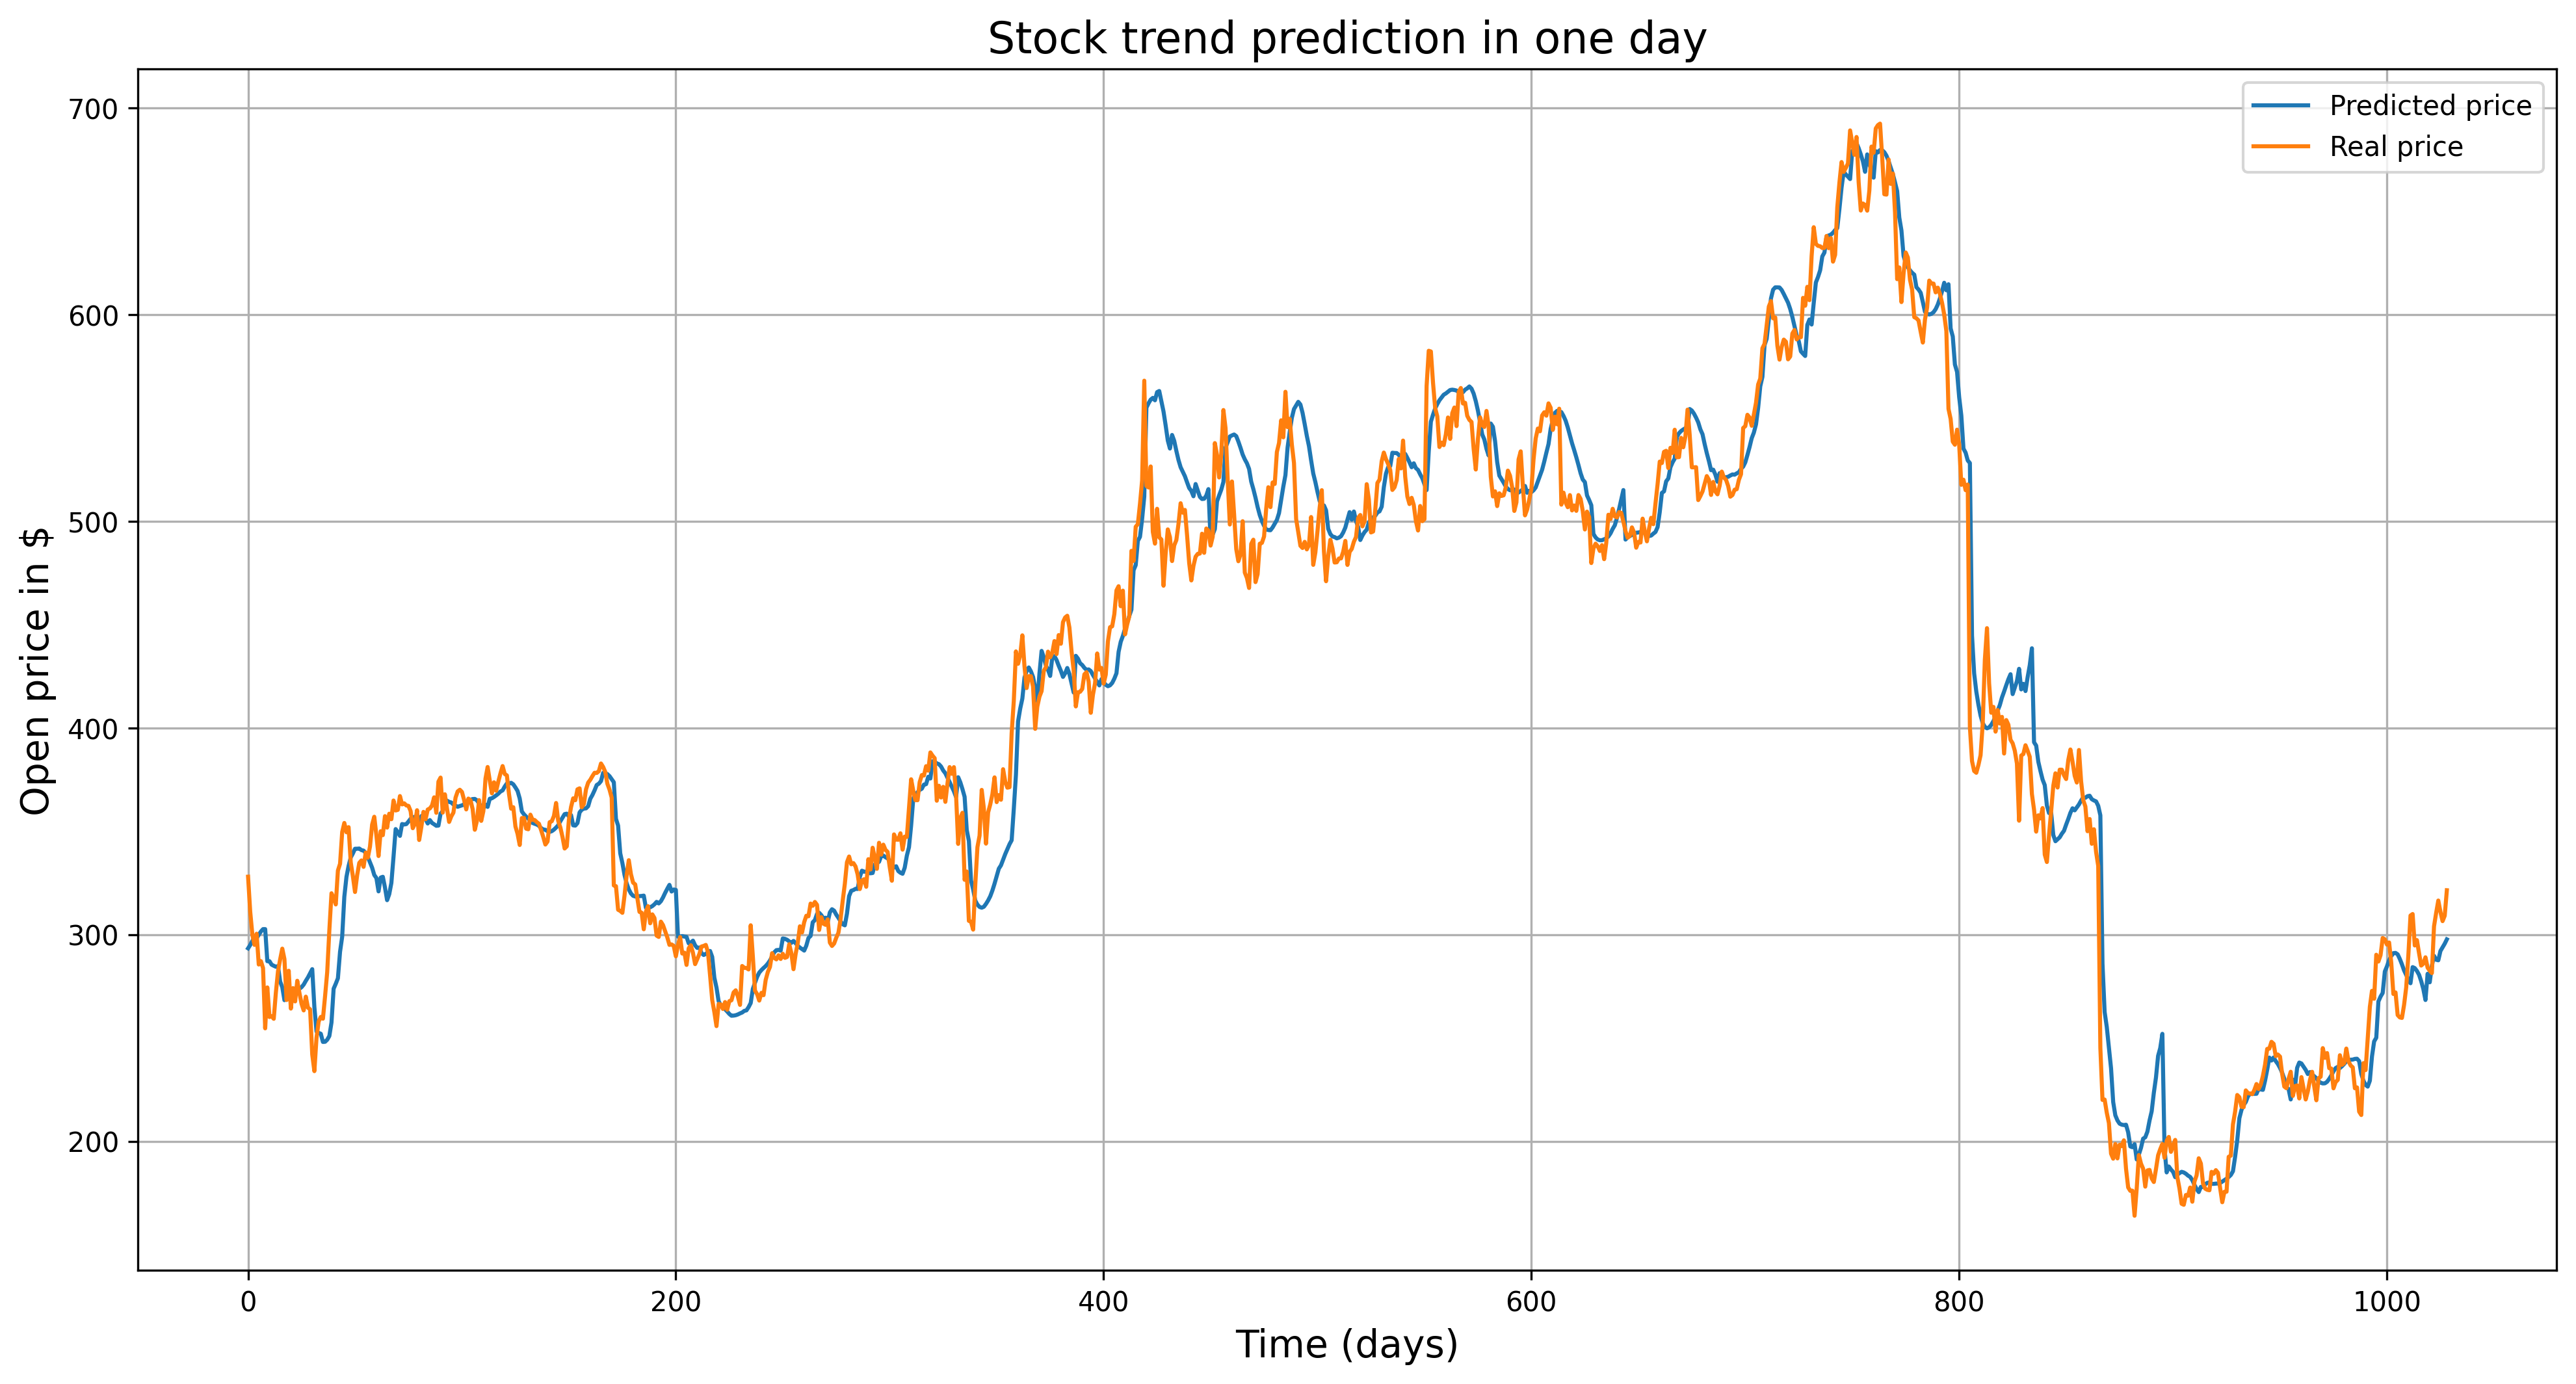

In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# VIETNAM

In [5]:
!pip install vnstock3 --upgrade
from vnstock import *
import pandas as pd

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
listing_companies().to_csv("companies.csv", encoding="utf-8-sig")
companies=pd.read_csv("companies.csv")

In [9]:
data_vn = companies[companies['ticker'] == 'VHC']
print(data_vn)

     Unnamed: 0 ticker comGroupCode                  organName  \
675         675    VHC         HOSE  Công ty Cổ phần Vĩnh Hoàn   

         organShortName organTypeCode comTypeCode                    icbName  \
675  Thủy sản Vĩnh Hoàn            DN          CT  Nuôi trồng nông & hải sản   

                                           icbNamePath          sector  ...  \
675  Hàng Tiêu dùng/Thực phẩm và đồ uống/Sản xuất t...  Hàng Tiêu dùng  ...   

    VNCOND VNCONS  VNENE  VNFIN  VNHEAL  VNIND   VNIT  VNMAT  VNREAL  VNUTI  
675  False   True  False  False   False  False  False  False   False  False  

[1 rows x 36 columns]


In [11]:
data_vn = pd.read_csv('VHC-VNINDEX-History.csv')
print(data_vn.head())

   Unnamed: 0    Open    High     Low   Close  Volume TradingDate
0           0  8014.0  8014.0  6772.0  6998.0  143660  2007-12-24
1           1  6998.0  7111.0  6998.0  6998.0   75990  2007-12-25
2           2  6998.0  6998.0  6772.0  6998.0   18760  2007-12-26
3           3  6941.0  6998.0  6941.0  6998.0   14660  2007-12-27
4           4  6941.0  7167.0  6941.0  7167.0   64510  2007-12-28


In [12]:
def prepare_data(company_data, window_size):
    X_data = []
    y_data = []

    # Only get the open price (replace index 2 if necessary)
    for i in range(1, len(company_data) - window_size - 1):
        first = company_data.iloc[i, 2]
        data_feature = []
        data_label = []

        # Get a window_size time frame for data feature
        for j in range(window_size):
            data_feature.append(company_data.iloc[i + j, 2])

        # Next value is the label (price of the next day) to be predicted
        data_label.append(company_data.iloc[i + window_size, 2])

        # Append new data sample (feature and label) to X_data and y_data
        X_data.append(np.array(data_feature).reshape(window_size, 1))
        y_data.append(np.array(data_label))

    return np.array(X_data), np.array(y_data)


In [13]:
window_size = 30

In [14]:
def normalize_data(X_train, y_train, X_val, y_val):
    X_train_norm = X_train.copy()
    y_train_norm = y_train.copy()
    X_val_norm = X_val.copy()
    y_val_norm = y_val.copy()

    for i in range(len(X_train)):
        min_feature = np.min(X_train[i])
        max_feature = np.max(X_train[i])
        if max_feature != min_feature:
            X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
            y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

    for i in range(len(X_val)):
        min_feature = np.min(X_val[i])
        max_feature = np.max(X_val[i])
        if max_feature != min_feature:
            X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
            y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

    return X_train_norm, y_train_norm, X_val_norm, y_val_norm


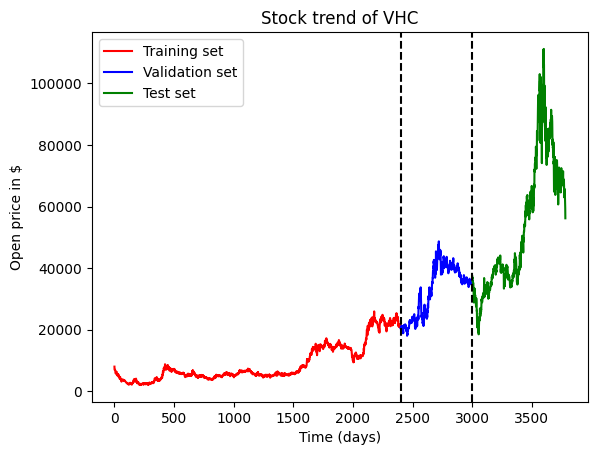

In [15]:
X_data, y_data = prepare_data(data_vn, window_size)
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Visualize the training, validation and test set
df_plot = data_vn['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of VHC")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)

In [16]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.8353 - mse: 0.8353 - val_loss: 0.2846 - val_mse: 0.2846
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 0.2464 - mse: 0.2464 - val_loss: 0.1756 - val_mse: 0.1756
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.1765 - mse: 0.1765 - val_loss: 0.1353 - val_mse: 0.1353
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - loss: 0.1417 - mse: 0.1417 - val_loss: 0.1066 - val_mse: 0.1066
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - loss: 0.1093 - mse: 0.1093 - val_loss: 0.1195 - val_mse: 0.1195


In [20]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MSE on the test set:  0.07297131706390955


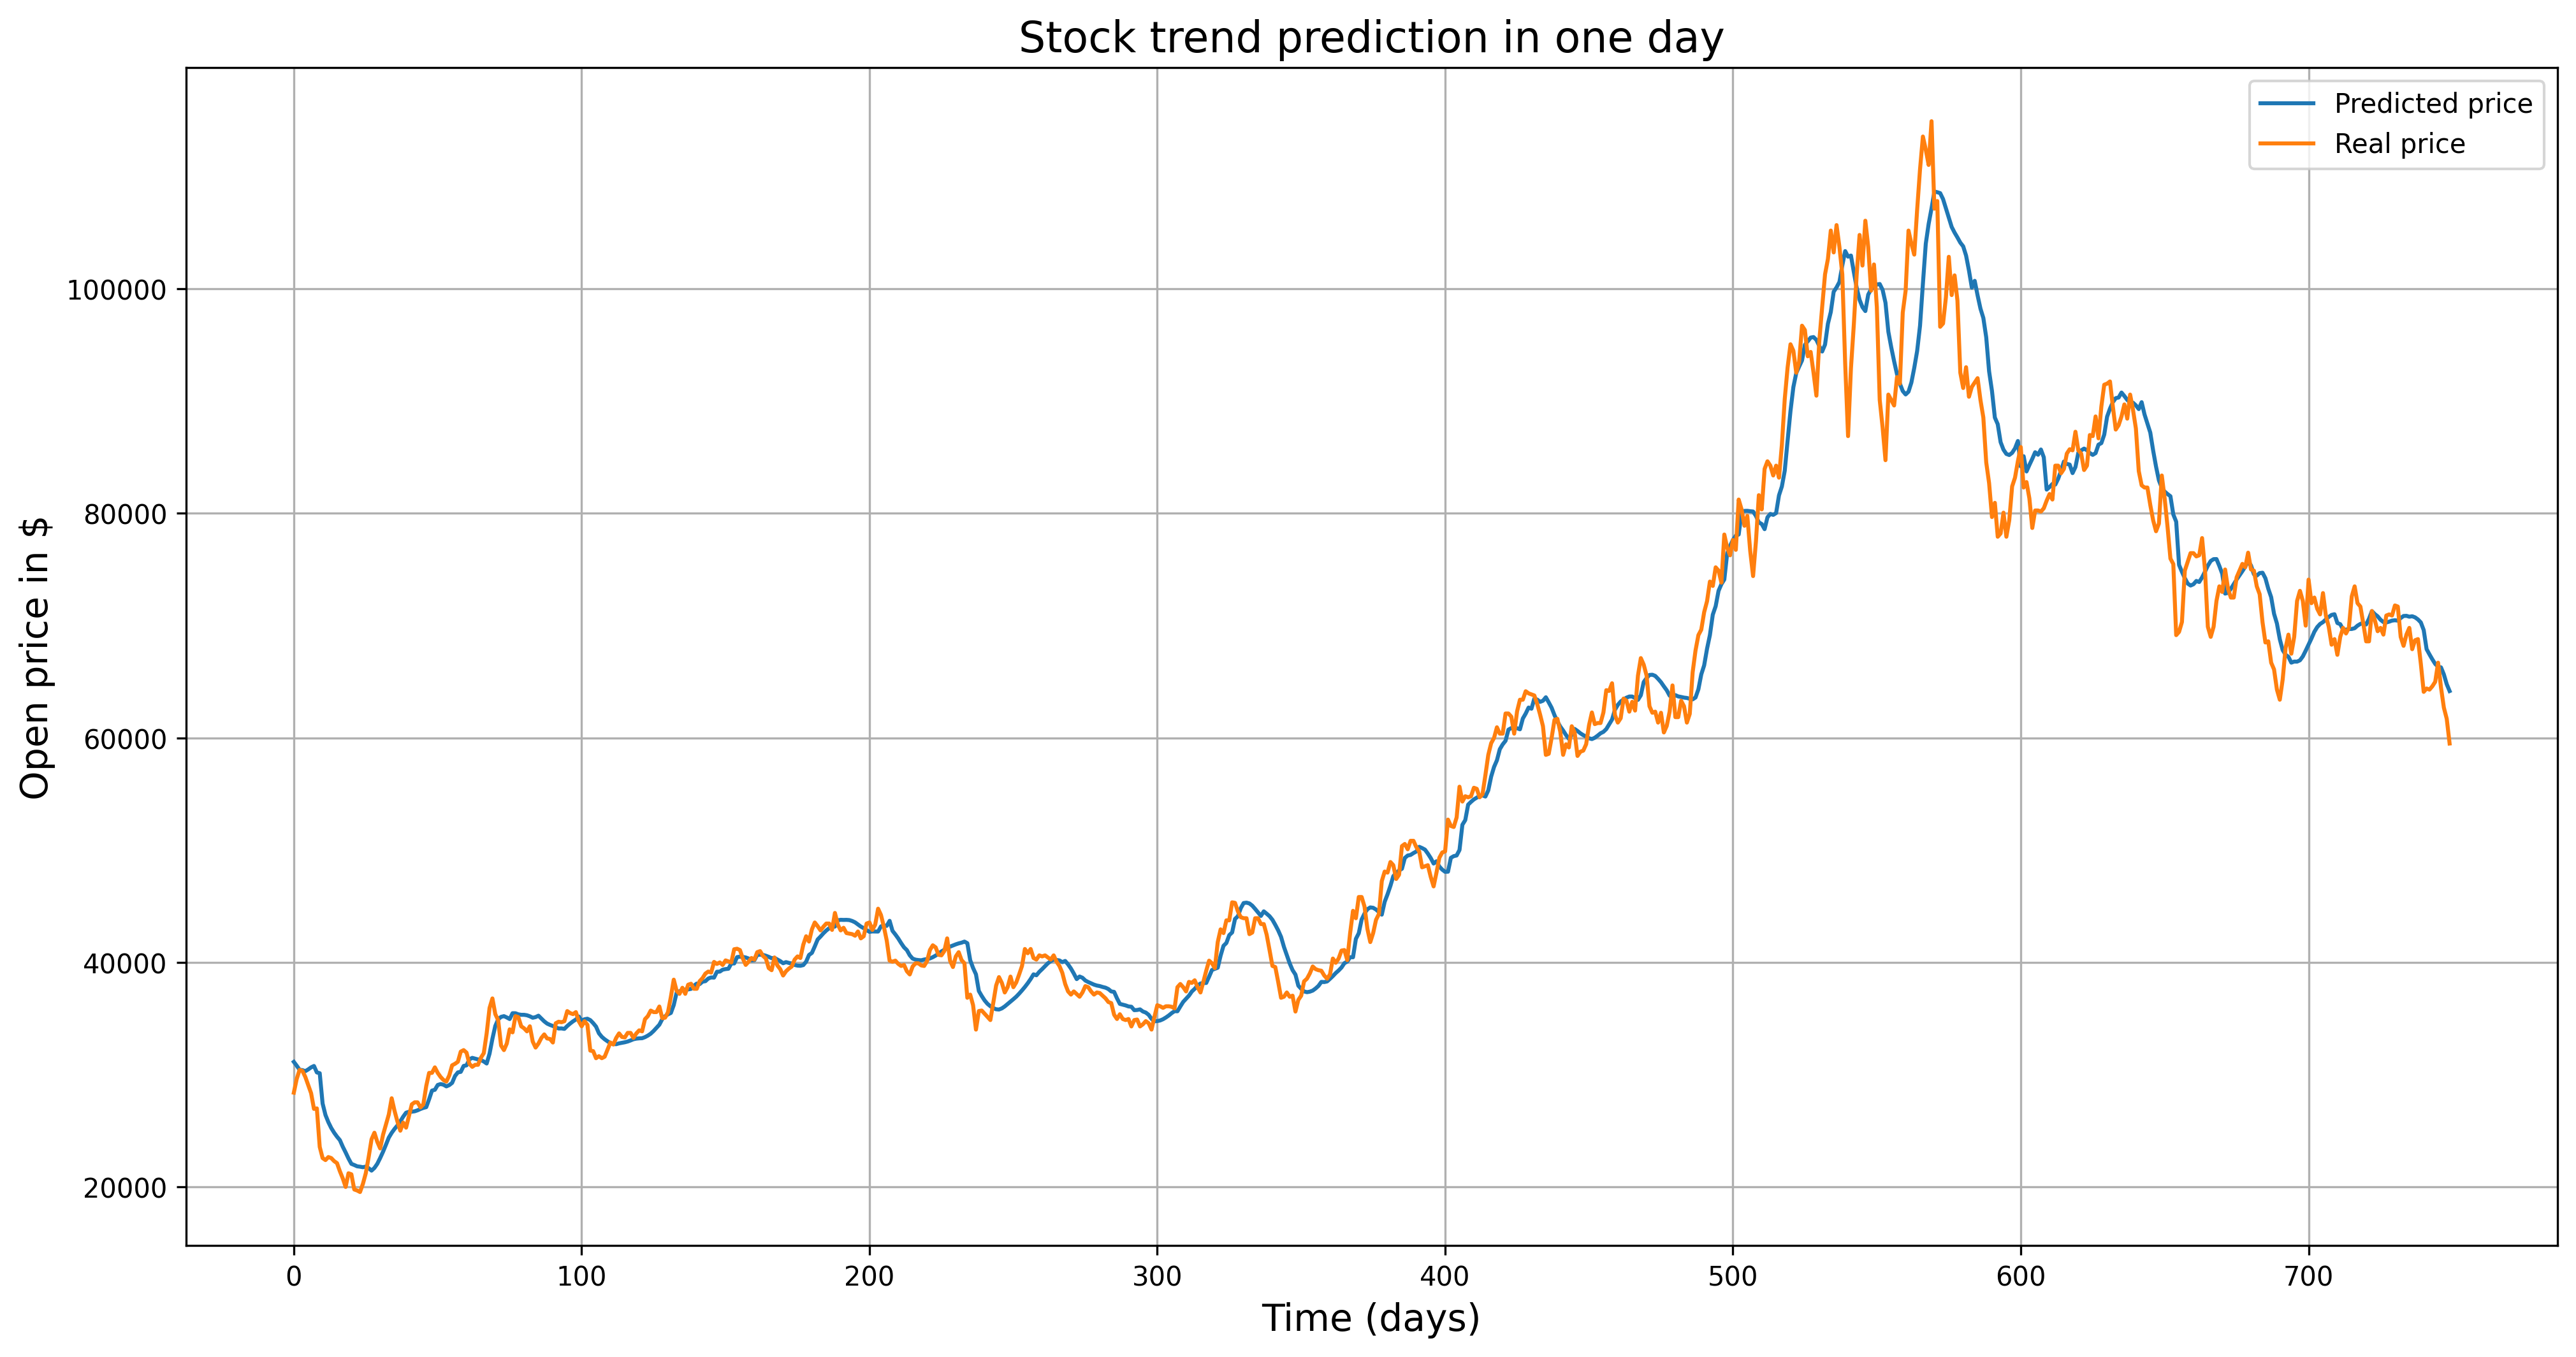

In [21]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# Buy/Sell Model

In [17]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=f6b669dbc72796a90b21228e22a94429e4a7e0bec57670a18374c550142a9cb8
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [18]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta

In [20]:
# Load data from csv file
data_vhc = pd.read_csv('VHC-VNINDEX-History.csv')

In [21]:
import pandas as pd
import pandas_ta as ta

# Assuming you have a DataFrame named 'historical_data' containing the historical price data

# Calculate technical indicators
indicators = pd.DataFrame()

# Simple Moving Average (SMA)
indicators['sma'] = ta.sma(data_appl['Close'], length=20)

# Exponential Moving Average (EMA)
indicators['ema'] = ta.ema(data_appl['Close'], length=20)

# Relative Strength Index (RSI)
indicators['rsi'] = ta.rsi(data_appl['Close'], length=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.macd(data_appl['Close'])
macd_line = macd.iloc[:, 0]  # Extract the MACD line (first column)

indicators['macd'] = macd_line

# Replace NaN values with the mean of each indicator
indicators = indicators.fillna(indicators.mean())

# Select the desired technical indicators
selected_indicators = indicators[['sma', 'ema', 'rsi', 'macd']]  # Replace with the indicators you want to use


# Merge the selected technical indicators with the historical data
combined_data = pd.concat([data_appl, selected_indicators], axis=1)

# Now you have the combined_data DataFrame that contains both historical price data and the selected technical indicators


In [22]:
combined_data

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate,sma,ema,rsi,macd
0,0,8014.0,8014.0,6772.0,6998.0,143660,2007-12-24,21886.579471,21884.487094,51.301494,111.002685
1,1,6998.0,7111.0,6998.0,6998.0,75990,2007-12-25,21886.579471,21884.487094,51.301494,111.002685
2,2,6998.0,6998.0,6772.0,6998.0,18760,2007-12-26,21886.579471,21884.487094,51.301494,111.002685
3,3,6941.0,6998.0,6941.0,6998.0,14660,2007-12-27,21886.579471,21884.487094,51.301494,111.002685
4,4,6941.0,7167.0,6941.0,7167.0,64510,2007-12-28,21886.579471,21884.487094,51.301494,111.002685
...,...,...,...,...,...,...,...,...,...,...,...
3777,3777,64400.0,64500.0,62700.0,62700.0,298624,2023-02-22,66445.000000,65785.687169,38.000617,-1470.511030
3778,3778,62600.0,62700.0,59000.0,60000.0,592090,2023-02-23,65945.000000,65234.669343,32.326924,-1747.991371
3779,3779,61700.0,61700.0,59100.0,59600.0,258230,2023-02-24,65445.000000,64698.034168,31.574787,-1977.379200
3780,3780,59500.0,59500.0,55900.0,56000.0,457534,2023-02-27,64760.000000,63869.649961,25.764680,-2421.744261


In [23]:
def determine_trading_point(data, window_size):
  labels = []
  for i in range(window_size, len(data) - window_size):
    current_price = data['Open'][i]
    prices_in_window = data['Open'][i - window_size : i + window_size + 1]
    threshold = np.percentile(prices_in_window,75)
    label = 1 if current_price >= threshold else 0
    labels.append(label)
  return labels

In [24]:
window_size = 15
from sklearn.model_selection import train_test_split
labels = determine_trading_point(combined_data, window_size = 15)
X_data = []
y_data = []
for i in range(window_size, len(combined_data) - window_size):
  feature = combined_data['Open'][i - window_size: i]
  X_data.append(feature)
  y_data.append(labels[i - window_size])
X_data = np.array(X_data)
y_data = np.array(y_data)


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten

In [26]:
from sklearn.preprocessing import MinMaxScaler
X_data = np.array(X_data)
y_data = np.array(y_data)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

model = tf.keras.Sequential()
model.add(LSTM(units=50, input_shape=(window_size, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="relu"))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=5, batch_size=512)

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 363ms/step - loss: 0.2200 - mse: 0.2200 - val_loss: 0.1818 - val_mse: 0.1818
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.1602 - mse: 0.1602 - val_loss: 0.1835 - val_mse: 0.1835
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.1686 - mse: 0.1686 - val_loss: 0.1798 - val_mse: 0.1798
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.1644 - mse: 0.1644 - val_loss: 0.1803 - val_mse: 0.1803
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.1631 - mse: 0.1631 - val_loss: 0.1808 - val_mse: 0.1808


In [27]:
loss, mse = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)
print("Test MSE:", mse)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1686 - mse: 0.1686
Test Loss: 0.17884275317192078
Test MSE: 0.17884275317192078


In [28]:
# Prepare the data sample
data_sample = combined_data.iloc[0:window_size][['Open']].values  # Replace 'Open' with the column you want to use

# Reshape and scale the data sample
data_sample = np.reshape(data_sample, (1, window_size, 1))
data_sample_scaled = scaler.transform(data_sample.reshape(data_sample.shape[0], -1)).reshape(data_sample.shape)

# Make predictions on the data sample
prediction = model.predict(data_sample_scaled)
predicted_class = 1 if prediction >= 0.5 else 0  # Adjust the threshold as needed

# Interpret the prediction
if predicted_class == 1:
    print("Predicted: Buy")
else:
    print("Predicted: Sell")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
Predicted: Sell


# Vietnam Portfolio

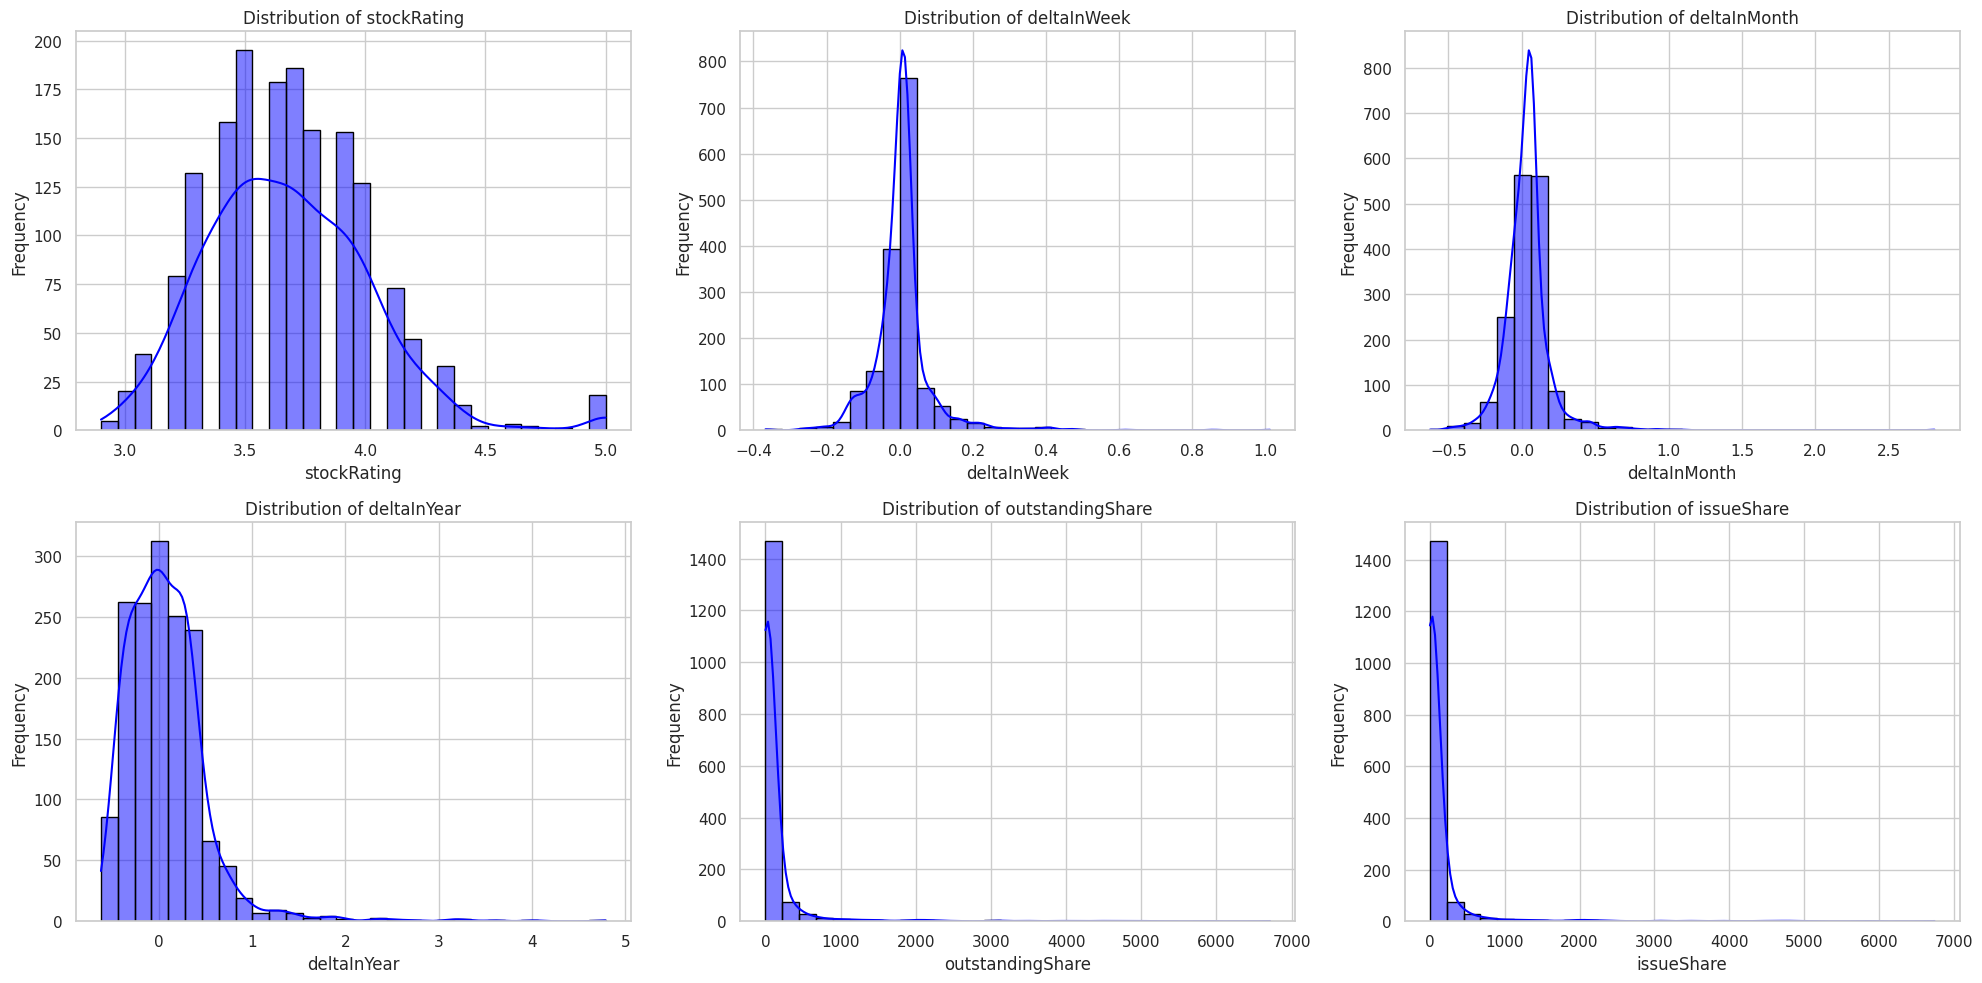



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



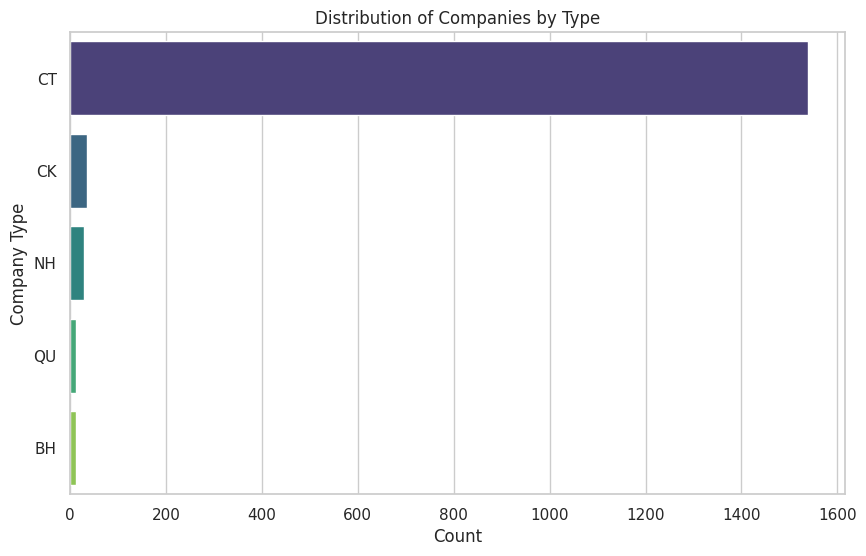

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace with your actual dataset)
df = pd.read_csv('ticker-overview.csv')

# Ensure columns are numeric where appropriate
numeric_columns = ['stockRating', 'deltaInWeek', 'deltaInMonth', 'deltaInYear', 'outstandingShare', 'issueShare']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, handling errors

# Plot settings
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))

# Plot each numeric column
for i, col in enumerate(numeric_columns, start=1):
    plt.subplot(2, 3, i)  # Adjust layout to fit all plots
    sns.histplot(df[col], kde=True, bins=30, color="blue", edgecolor="black")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Plot companyType as a bar chart
plt.figure(figsize=(10, 6))
sns.countplot(y="companyType", data=df, palette="viridis", order=df['companyType'].value_counts().index)
plt.title("Distribution of Companies by Type")
plt.xlabel("Count")
plt.ylabel("Company Type")
plt.show()


In [37]:
import pandas as pd

# Load the data
file_path = "ticker-overview.csv"  # Replace with the path to your CSV file
data = pd.read_csv(file_path)

def filter_companies(df):
    # Step 1: Filter for companies with positive long-term growth (deltaInYear > 5%)
    df = df[df['deltaInYear'] > 1]
    print(f"Step 1: Positive long-term growth: {len(df)} rows remaining")

    # Step 2: Ensure companies have recent growth (deltaInMonth > 3% and deltaInWeek > 1%)
    df = df[(df['deltaInMonth'] > 0.03) & (df['deltaInWeek'] > 0.01)]
    print(f"Step 2: Recent growth: {len(df)} rows remaining")

    # Step 3: Select companies with high stock ratings (stockRating > 3.5)
    df = df[df['stockRating'] > 3.5]
    print(f"Step 3: High stock ratings: {len(df)} rows remaining")

    # Step 4: Ensure market liquidity (outstandingShare > median)
    if len(df) > 0:  # Check to avoid empty DataFrame errors
        median_outstanding = df['outstandingShare'].median()
        df = df[df['outstandingShare'] > median_outstanding]
        print(f"Step 4: Market liquidity: {len(df)} rows remaining")

    # Step 5: Diversify portfolio based on companyType
    if len(df) > 0:  # Check to avoid empty DataFrame errors
        diversified = (
            df.groupby('companyType', group_keys=False)
              .apply(lambda x: x.nlargest(3, 'stockRating'))  # Select top 3 by rating within each group
        )
        print(f"Step 5: Diversified portfolio: {len(diversified)} rows selected")
        return diversified

    return df  # Return empty DataFrame if all rows are filtered out



# Apply filtering
selected_companies = filter_companies(data)

# Display the selected portfolio
print("Selected Portfolio:")
print(selected_companies)

# Save the portfolio to a new CSV file
selected_companies.to_csv("selected_portfolio.csv", index=False)


Step 1: Positive long-term growth: 43 rows remaining
Step 2: Recent growth: 31 rows remaining
Step 3: High stock ratings: 9 rows remaining
Step 4: Market liquidity: 4 rows remaining
Step 5: Diversified portfolio: 3 rows selected
Selected Portfolio:
      Unnamed: 0 exchange                  shortName  industryID  \
1233        1233     HOSE        Thiết bị Siêu Thanh       312.0   
538          538    UPCOM  Đầu tư XD Dân dụng Hà Nội       336.0   
297          297    UPCOM     Cấp thoát nước Cần Thơ       277.0   

      industryIDv2                       industry   industryEn  \
1233        9574.0            Công nghệ Thông tin   Technology   
538         8633.0                   Bất động sản  Real Estate   
297         7577.0  Điện, nước & xăng dầu khí đốt    Utilities   

      establishedYear  noEmployees  noShareholders  ...  deltaInMonth  \
1233           1994.0        563.0           882.0  ...         0.637   
538            2013.0        202.0           165.0  ...         0.2

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [40]:
from tabulate import tabulate
csv_file_path = 'selected_portfolio.csv'  # Replace with the actual path to your CSV file
data_port = pd.read_csv(csv_file_path)

print(data_port)
print(tabulate(df, headers='keys', tablefmt='grid'))

   Unnamed: 0 exchange                  shortName  industryID  industryIDv2  \
0        1233     HOSE        Thiết bị Siêu Thanh       312.0        9574.0   
1         538    UPCOM  Đầu tư XD Dân dụng Hà Nội       336.0        8633.0   
2         297    UPCOM     Cấp thoát nước Cần Thơ       277.0        7577.0   

                        industry   industryEn  establishedYear  noEmployees  \
0            Công nghệ Thông tin   Technology           1994.0        563.0   
1                   Bất động sản  Real Estate           2013.0        202.0   
2  Điện, nước & xăng dầu khí đốt    Utilities           2004.0        456.0   

   noShareholders  ...  deltaInMonth deltaInYear  outstandingShare  \
0           882.0  ...         0.637       1.651              25.7   
1           165.0  ...         0.257       4.025              24.6   
2           232.0  ...         0.064       1.139              28.0   

   issueShare  companyType  ticker  status  code message traceId  
0        25.7     

In [55]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv("ticker-overview.csv")

# Normalize relevant columns
scaler = MinMaxScaler()
data[['deltaInYear_norm', 'deltaInMonth_norm', 'foreignPercent_norm', 'outstandingShare_norm']] = scaler.fit_transform(
    data[['deltaInYear', 'deltaInMonth', 'foreignPercent', 'outstandingShare']]
)

# Calculate Risk Score
data['risk_score'] = (
    0.3 * data['deltaInYear_norm'] +
    0.3 * data['deltaInMonth_norm'] +
    0.2 * (1 - data['foreignPercent_norm']) +
    0.2 * data['outstandingShare_norm']
)

# Filter Risky Companies
risky_companies = data[data['risk_score'] > 0.5]
print("Risky Companies:\n", risky_companies[['shortName', 'risk_score']])


Risky Companies:
                       shortName  risk_score
374            Du lịch Đồng Nai    0.595235
496      Đảm bảo GTĐT Hải Phòng    0.529277
538   Đầu tư XD Dân dụng Hà Nội    0.535377
1540          Bột mỳ Vinafood 1    0.546088
